# Mask R-CNN - Inspect Apple Trained Model

Code and visualizations to test, debug, and evaluate the Mask R-CNN model.

In [1]:
# #!pip install tqdm
# !pip install sklearn

In [2]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import apple_wandb as apple
from tqdm import tqdm #<추가
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
print(MODEL_DIR)

# Path to Ballon trained weights
# You can download this file from the Releases page
# https://github.com/matterport/Mask_RCNN/releases
APPLE_WEIGHTS_PATH = os.path.join(MODEL_DIR,"apple20201126T0734/mask_rcnn_apple_0125.h5")  # TODO: update this path
print(APPLE_WEIGHTS_PATH)

Using TensorFlow backend.


1 Physical GPUs, 1 Logical GPUs


wandb: Currently logged in as: apple_diseases_detectoin (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.10.11 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


/tf/Mask_RCNN/logs
/tf/Mask_RCNN/logs/apple20201126T0734/mask_rcnn_apple_0125.h5


## Configurations

In [3]:
config = apple.AppleConfig()
APPLE_DIR = os.path.join(ROOT_DIR, "samples/apple/dataset_3cls")

In [4]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
#     BACKBONE= "resnet50"
#     DETECTION_MIN_CONFIDENCE = 0.8
#     IMAGE_MAX_DIM =1024
#     IMAGE_MIN_DIM =512
#     IMAGE_RESIZE_MODE = "square"
#     LAYER_STAGE ="heads"
#     LEARNING_RATE =0.001
#     LEARNING_MOMENTUM = 0.7
#     OPTIMIZER ="SGD"
#     ROI_POSITIVE_RATIO =0.33
#     RPN_NMS_THRESHOLD =0.6
#     STEPS_PER_EPOCH =145
#     TRAIN_BN = False
#     TRAIN_ROIS_PER_IMAGE = 200
#     VALIDATION_STEPS =50
#     WEIGHT_DECAY =0.0001
#     RPN_ANCHOR_SCALES = (16, 32, 64, 128, 256)            #  (32, 64, 128, 256, 512)
#     DETECTION_NMS_THRESHOLD=0.3
    
config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet50
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.5
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                19
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE          

## Notebook Preferences

In [5]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0 --> cpu:0이 cpu지정

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [6]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [7]:
dataset = apple.AppleDataset()
dataset.image_ids

[]

## Load Validation Dataset

In [8]:
# Load validation dataset
dataset = apple.AppleDataset()
dataset.load_apple(APPLE_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

{'Bitter rot': True}
{'Bitter rot': True}
{'Bitter rot': True}
{'Bitter rot': True}
{'Bitter rot': True}
{'Bitter rot': True}
{'Bitter rot': True}
{'Bitter rot': True}
{'Bitter rot': True}
{'Bitter rot': True}
{'Mar blotch': True}
{'Mar blotch': True}
{'Mar blotch': True}
{'Mar blotch': True}
{'Mar blotch': True}
{'Mar blotch': True}
{'Mar blotch': True}
{'Mar blotch': True}
{'Mar blotch': True}
{'Mar blotch': True}
{'White rot': True}
{'White rot': True}
{'White rot': True}
{'White rot': True}
{'White rot': True}
{'White rot': True}
{'White rot': True}
{'White rot': True}
{'White rot': True}
{'White rot': True}
{'Sooty/Fly': True}
{'Sooty/Fly': True}
{'Sooty/Fly': True}
{'Sooty/Fly': True}
{'Sooty/Fly': True}
{'Sooty/Fly': True}
{'Sooty/Fly': True}
{'Sooty/Fly': True}
{'brown rot': True}
{'brown rot': True}
{'brown rot': True}
{'brown rot': True}
{'brown rot': True}
{'brown rot': True}
{'brown rot': True}
{'brown rot': True}
{'brown rot': True}
{'brown rot': True}
{'Normal': True}
{'N

## Load Model

In [9]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
box_ind is deprecated, use box_indices instead


Instructions for updating:
Use `tf.cast` instead.


In [10]:
# Set path to balloon weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
weights_path = model.find_last()

# Load weights
print("Loading weights ", APPLE_WEIGHTS_PATH)
model.load_weights(APPLE_WEIGHTS_PATH, by_name=True)

Loading weights  /tf/Mask_RCNN/logs/apple20201126T0734/mask_rcnn_apple_0125.h5
Re-starting from epoch 125


## Run Detection

In [114]:
def result_view():
    global APs,class_score
    for image_id in dataset.image_ids:
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
        info = dataset.image_info[image_id]
        target = dataset.class_names[info['num_ids'][0]]
        print("image ID: {}.{} ({}) {}".format(info["source"], info["num_ids"][0], image_id, 
                                               dataset.image_reference(image_id)))
        
        # Run object detection
        ax = get_ax(1)
        results = model.detect([image], verbose=1)
        r = results[0]
        print(r['class_ids'])
               
#         visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
#                                     dataset.class_names, r['scores'], ax=ax,
#                                     title="Predictions")
#         splash = apple.color_splash(image, r['masks'])
#         display_images([splash], cols=1)
        
        
        
        
        AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask, r['rois'], r['class_ids'], r['scores'], r['masks'])
        add_class_score = {'gt':target,'gt_id':info["num_ids"][0],'pred':dataset.class_names[r['class_ids'][0] if len(r['class_ids'])>0 else 0],
                           'pred_id': r['class_ids'][0] if len(r['class_ids'])>0 else 0, 'recall':np.mean(recalls)}

        APs.append(AP)
        print(AP, precisions, recalls, overlaps)
        class_score= class_score.append(add_class_score, ignore_index=True)
        
    mAP = np.mean(APs)
    return mAP


image ID: apple.1 (0) /tf/Mask_RCNN/samples/apple/dataset_3cls/val/Bitter_rot (1).jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[4]
gt_boxes: [[279 247 665 645]]
0.0 [0. 0. 0.] [0. 0. 1.] [[0.85206926]]
image ID: apple.1 (1) /tf/Mask_RCNN/samples/apple/dataset_3cls/val/Bitter_rot (6).jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)   

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


[4 4]
gt_boxes: [[311 145 460 330]
 [459 720 587 883]
 [579 582 640 712]]
0.3333333432674408 [1.  1.  0.5 0. ] [0.         0.33333334 0.33333334 1.        ] [[8.8841802e-01 0.0000000e+00 0.0000000e+00]
 [1.4129508e-01 0.0000000e+00 4.5797431e-05]]
image ID: apple.4 (21) /tf/Mask_RCNN/samples/apple/dataset_3cls/val/white_rot_val (2).jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  254.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  130.30000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32
[4]
gt_boxes: [[322 335 634 659]]
1.0 [1. 1. 0.] [0. 1. 1.] [[0.9091863]]
image ID: apple.4 (22) /tf/Mask_RCNN/samples/apple/dataset_3cls/val/white_rot_val (3).jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  2

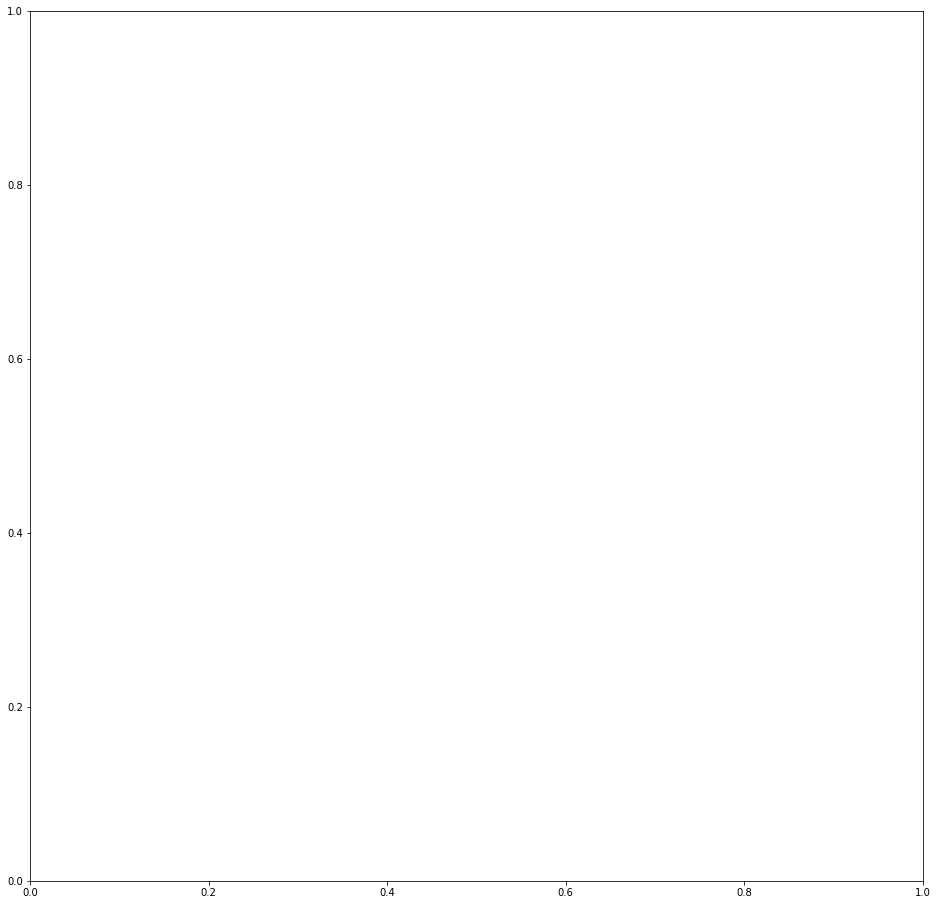

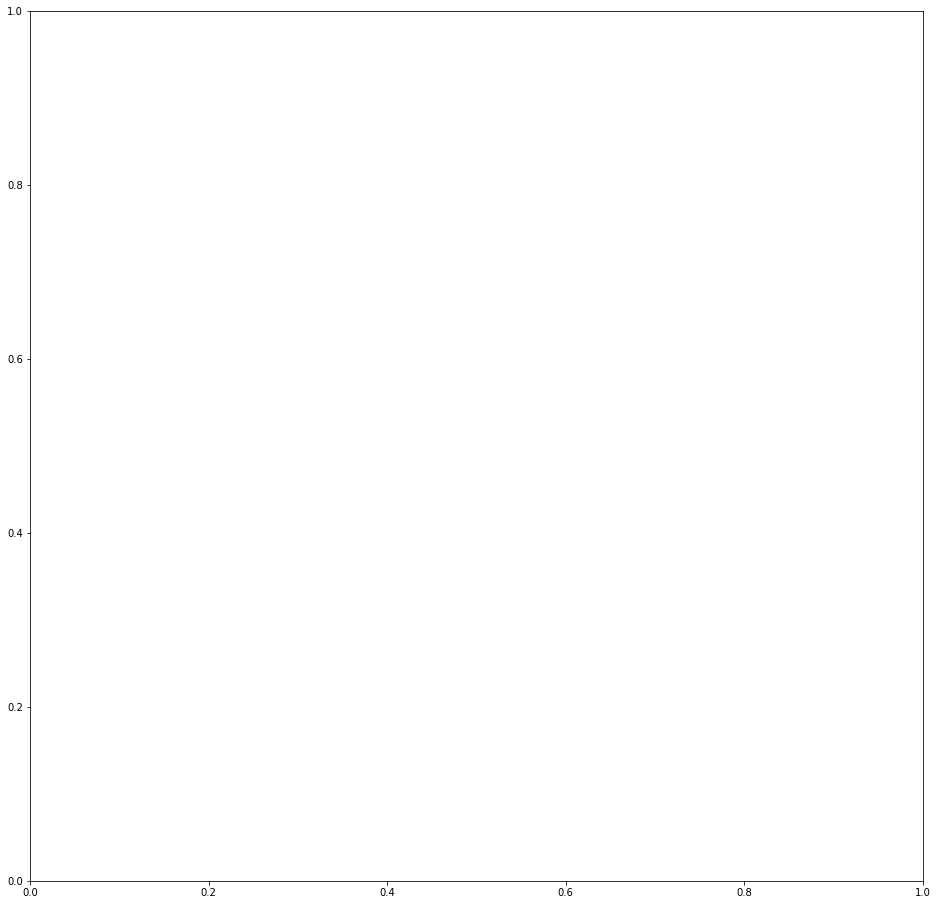

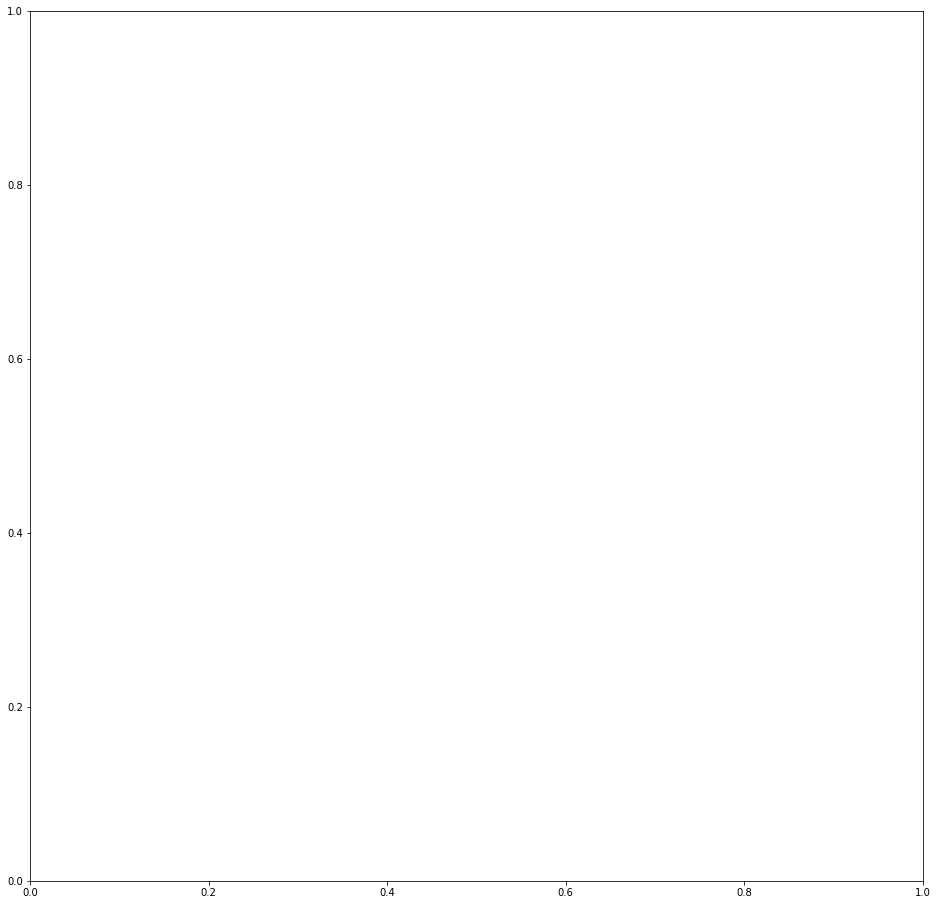

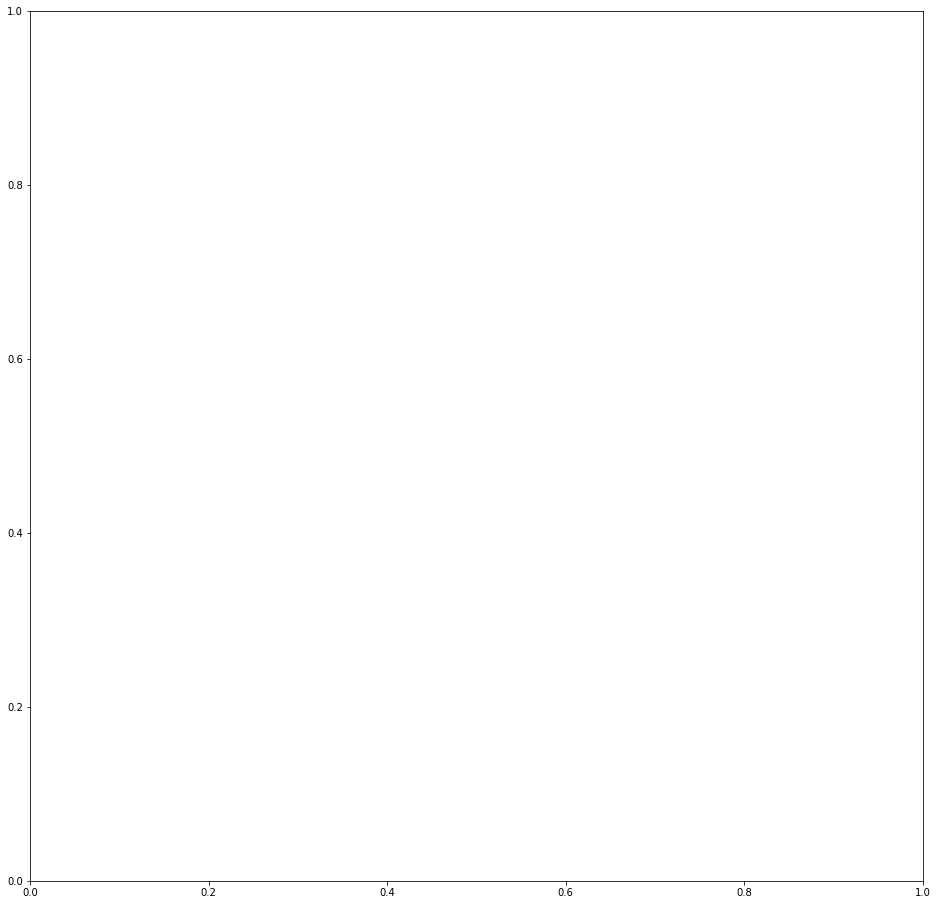

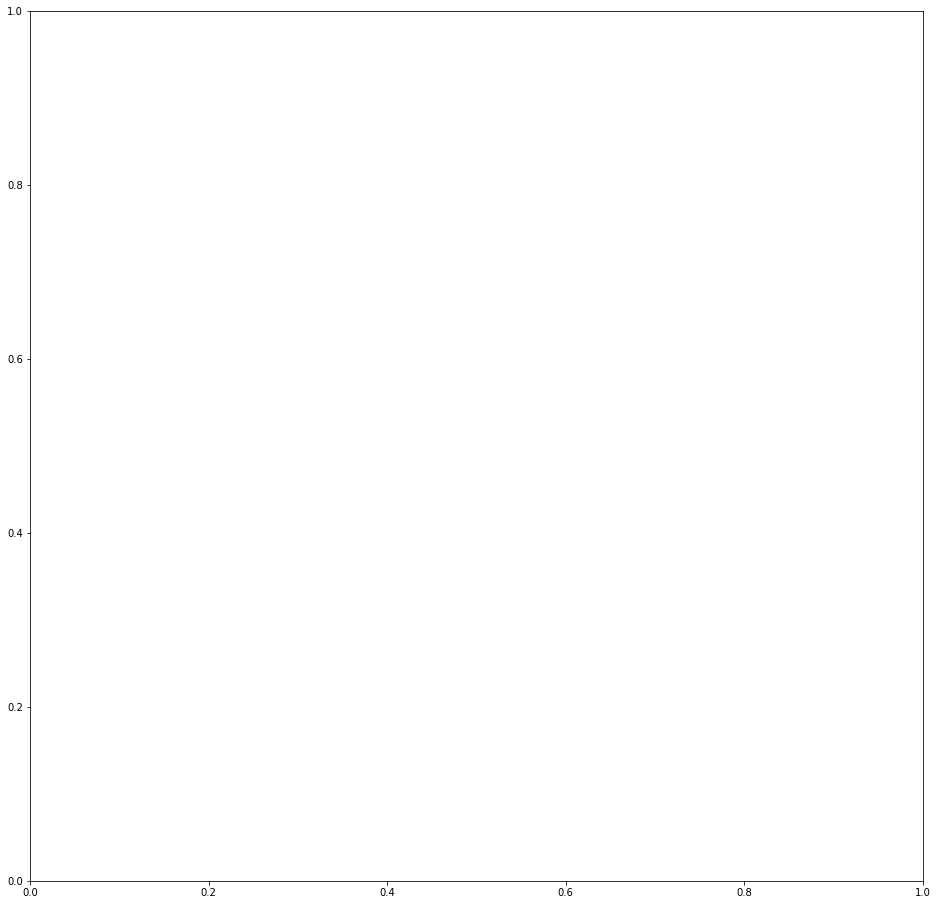

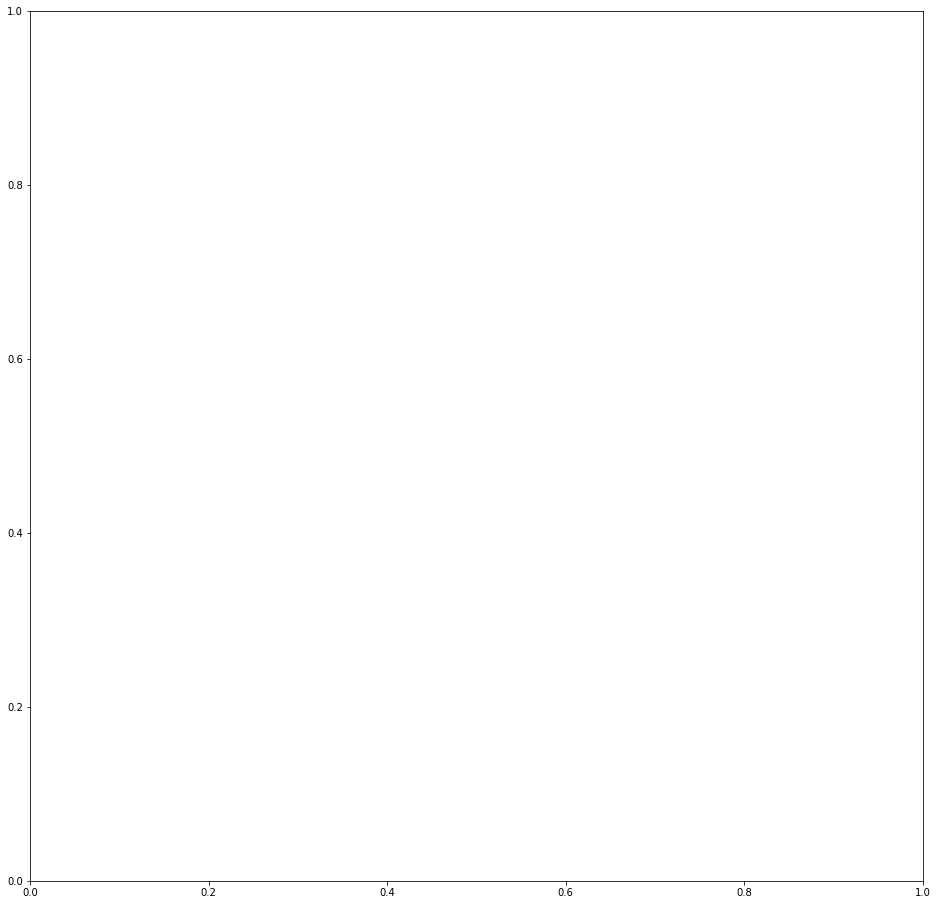

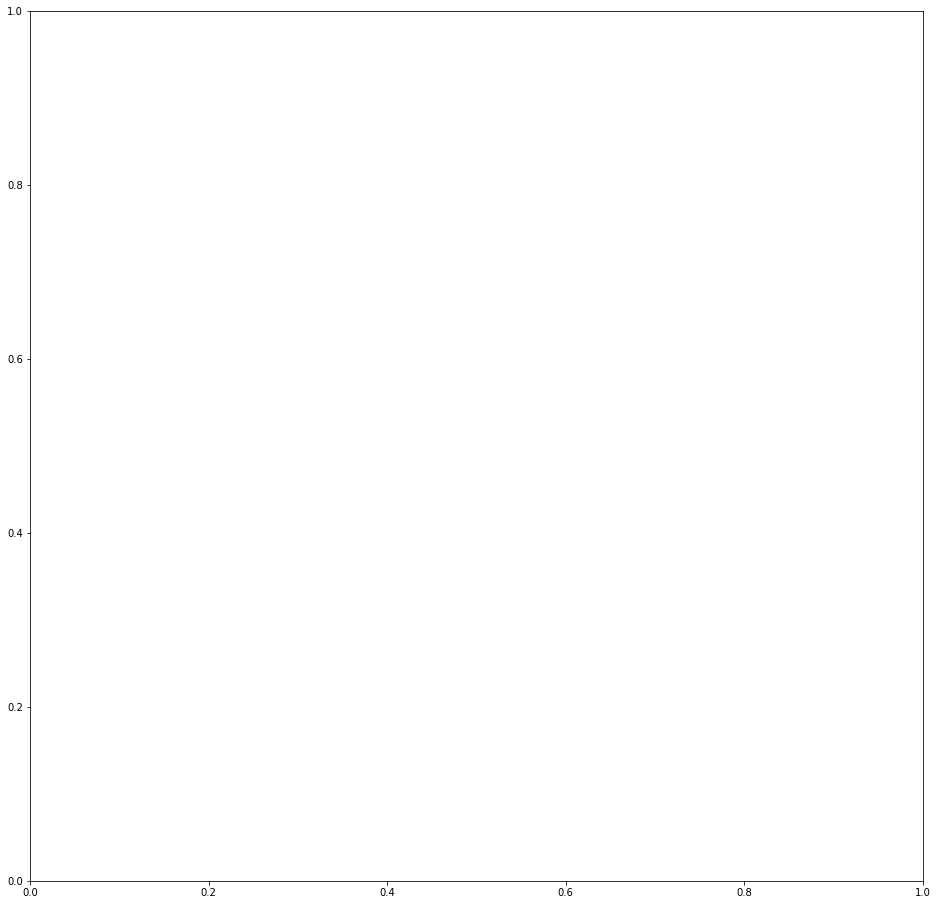

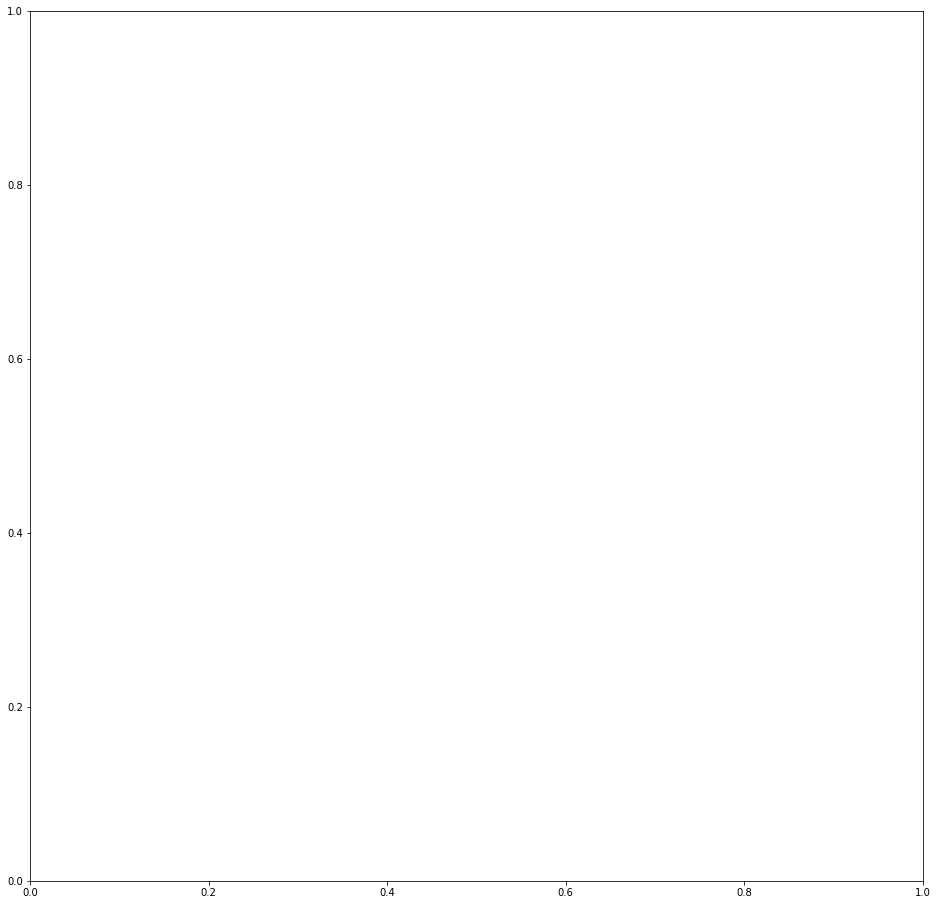

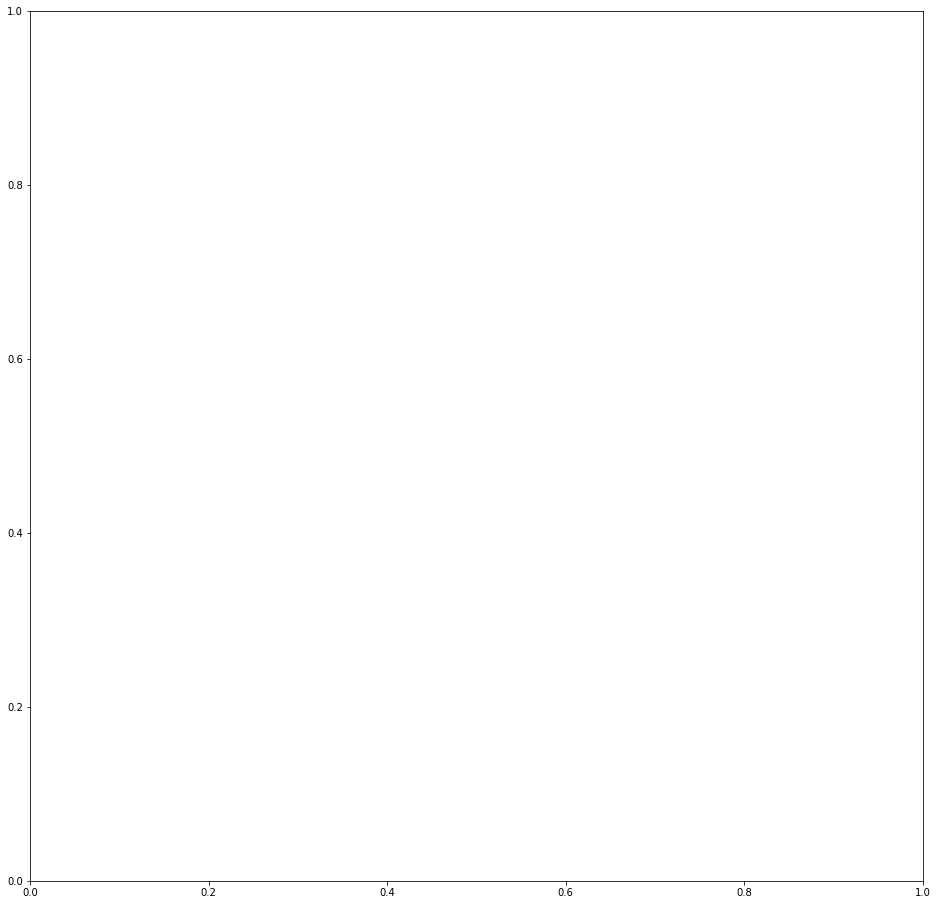

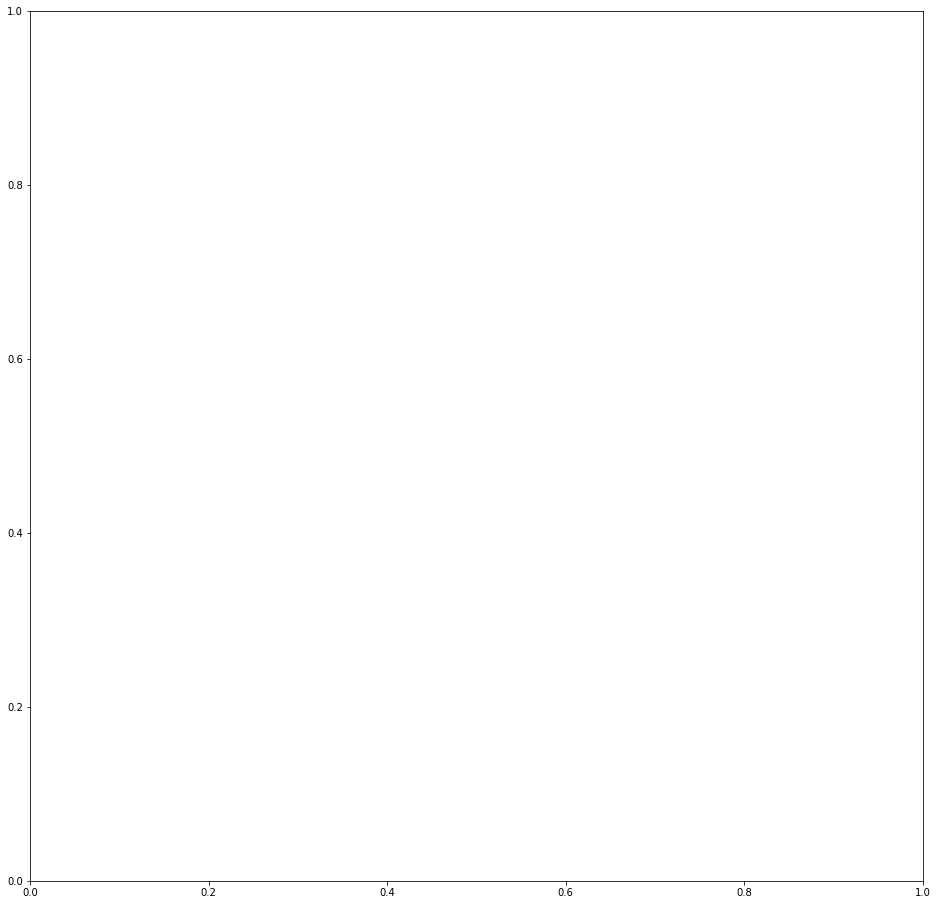

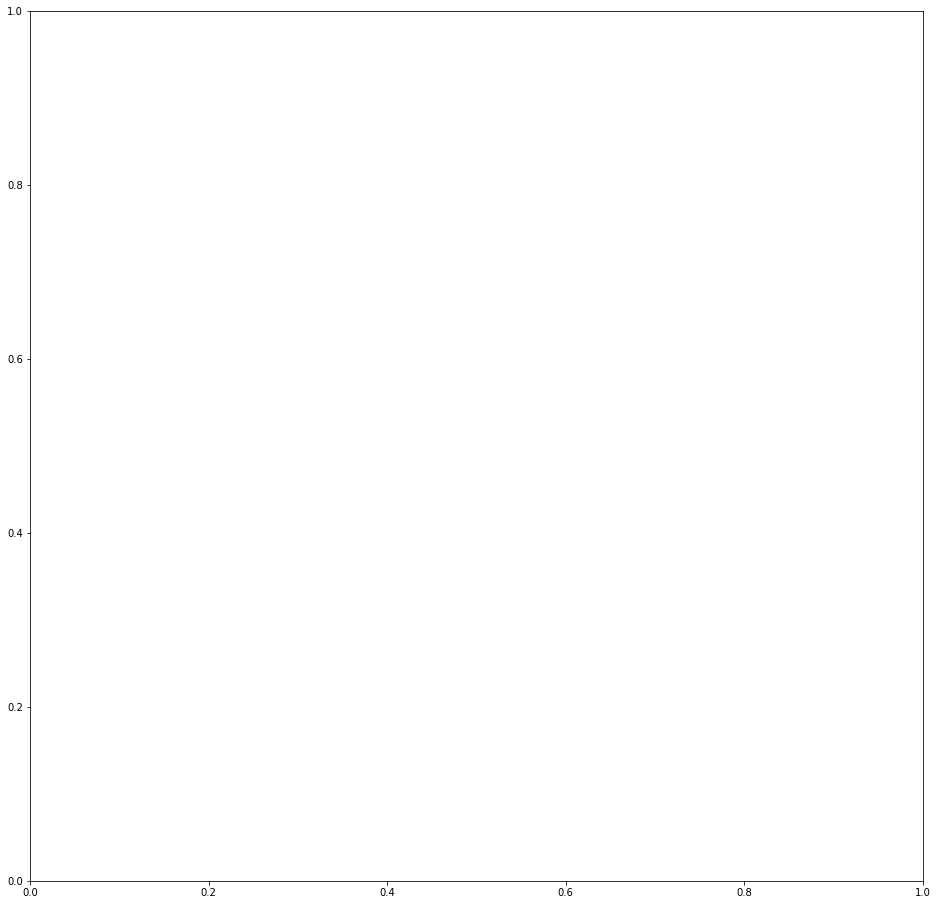

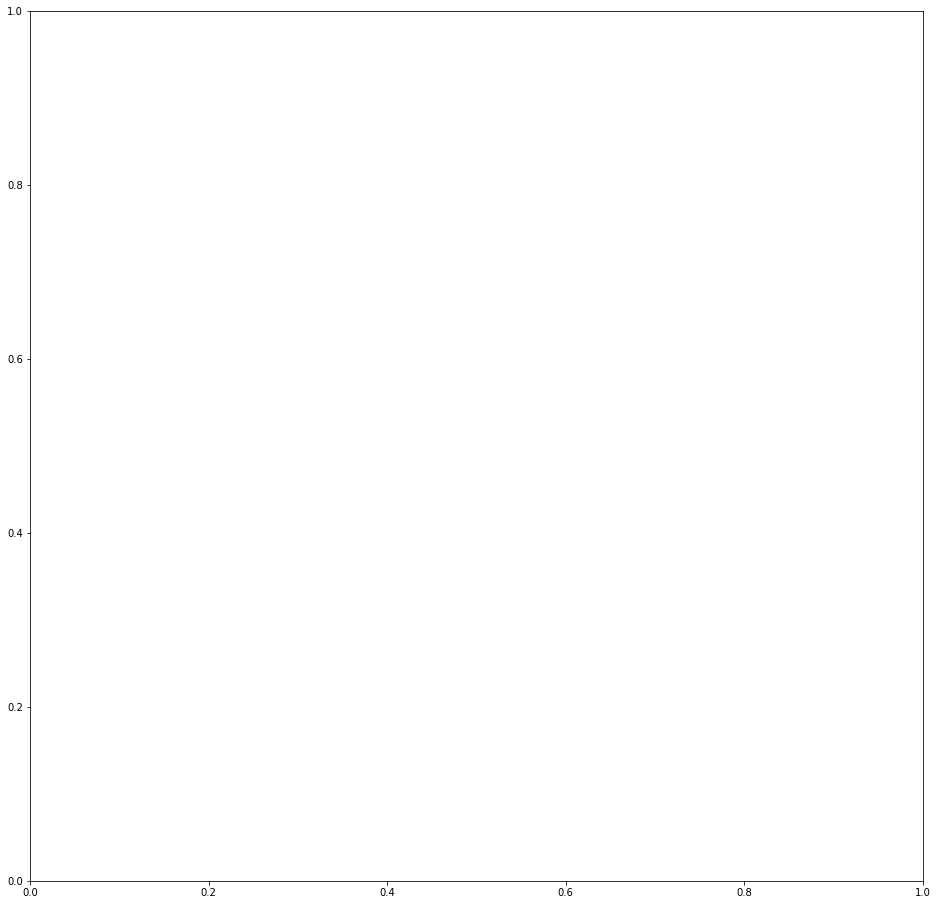

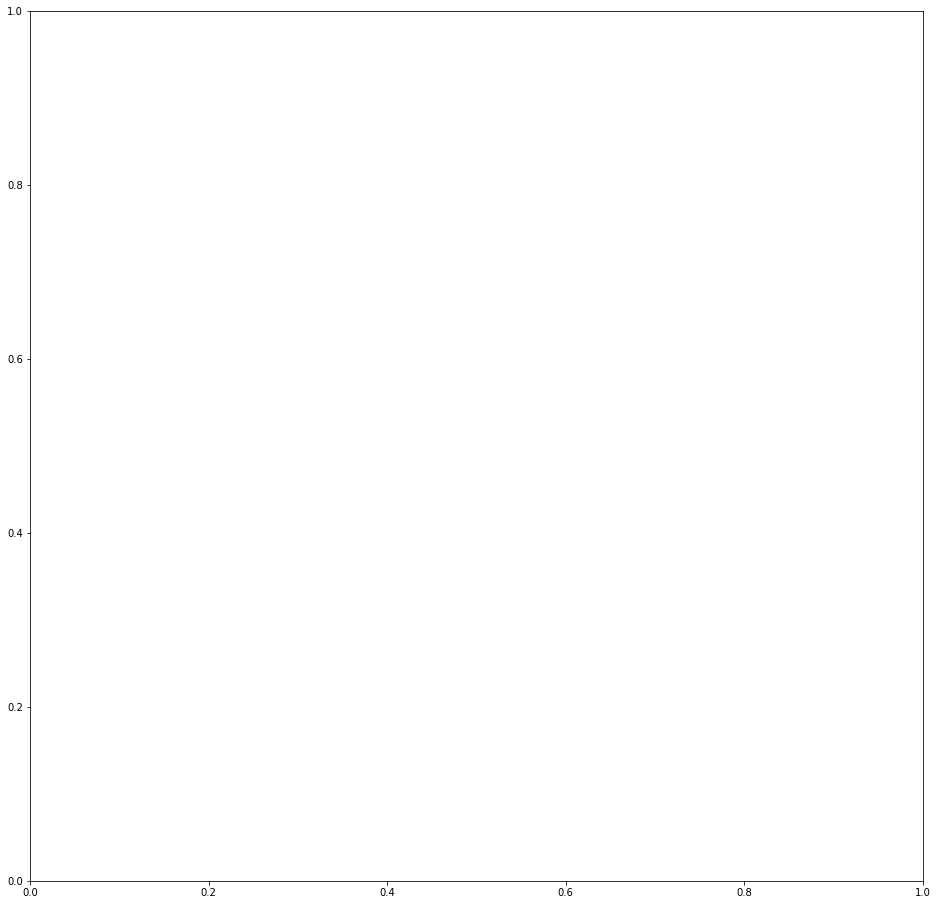

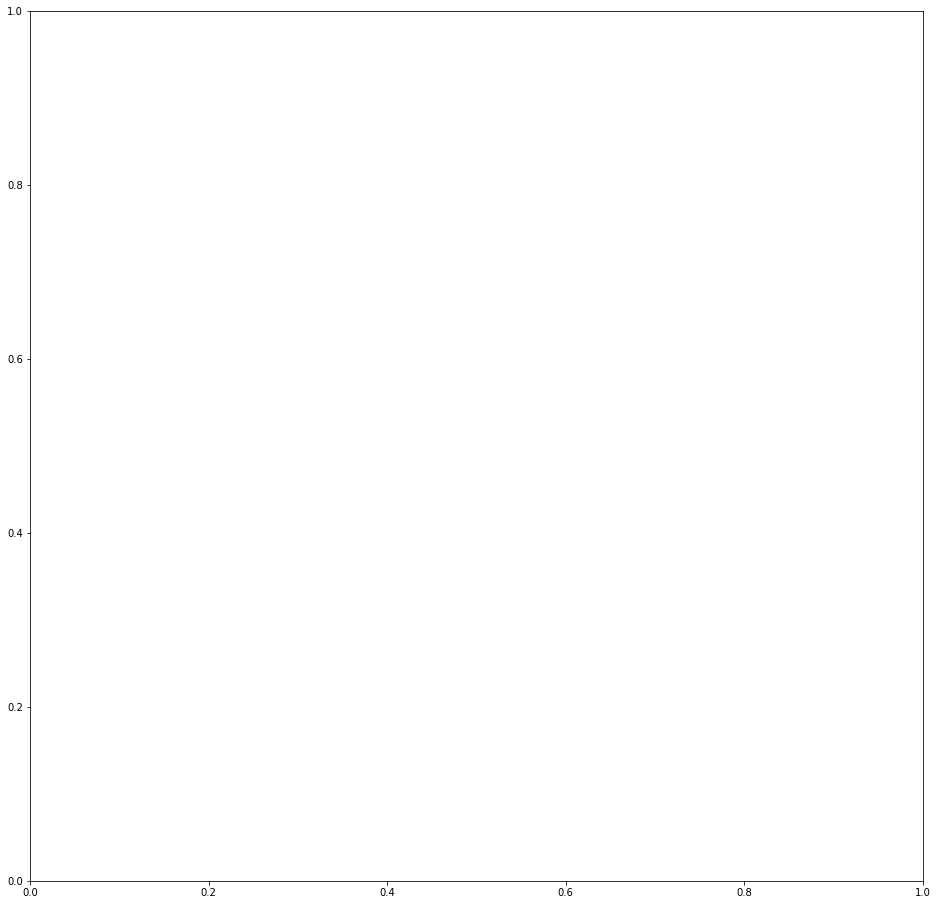

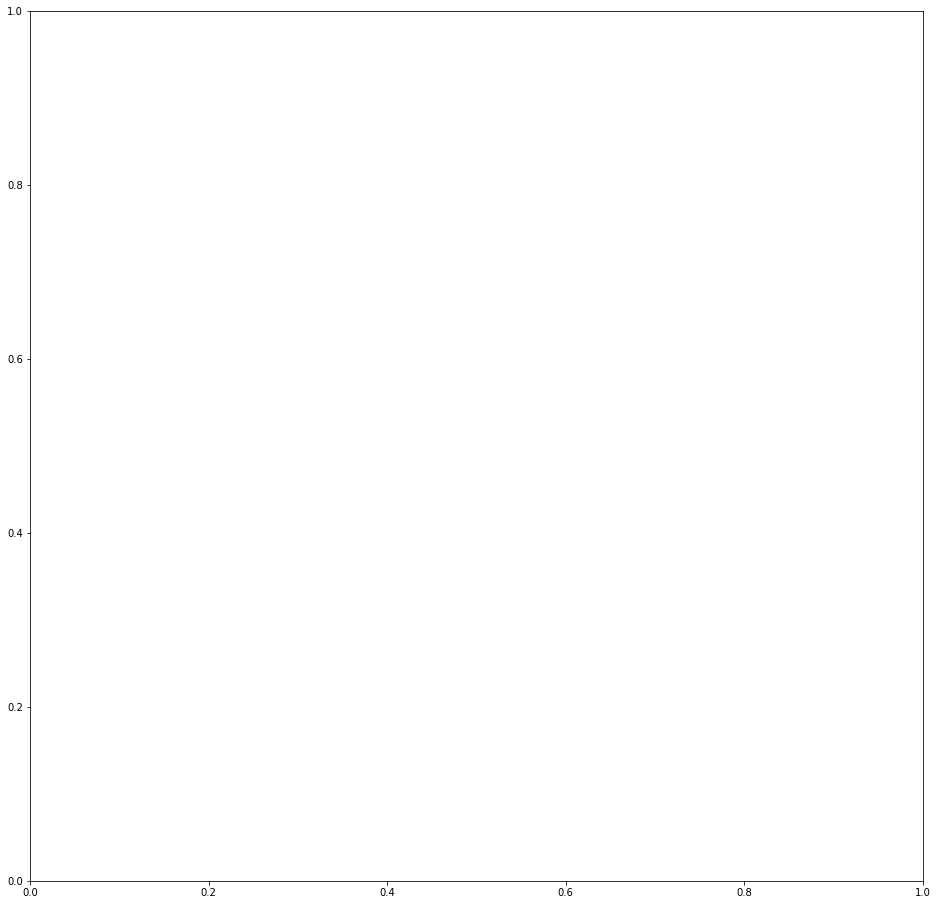

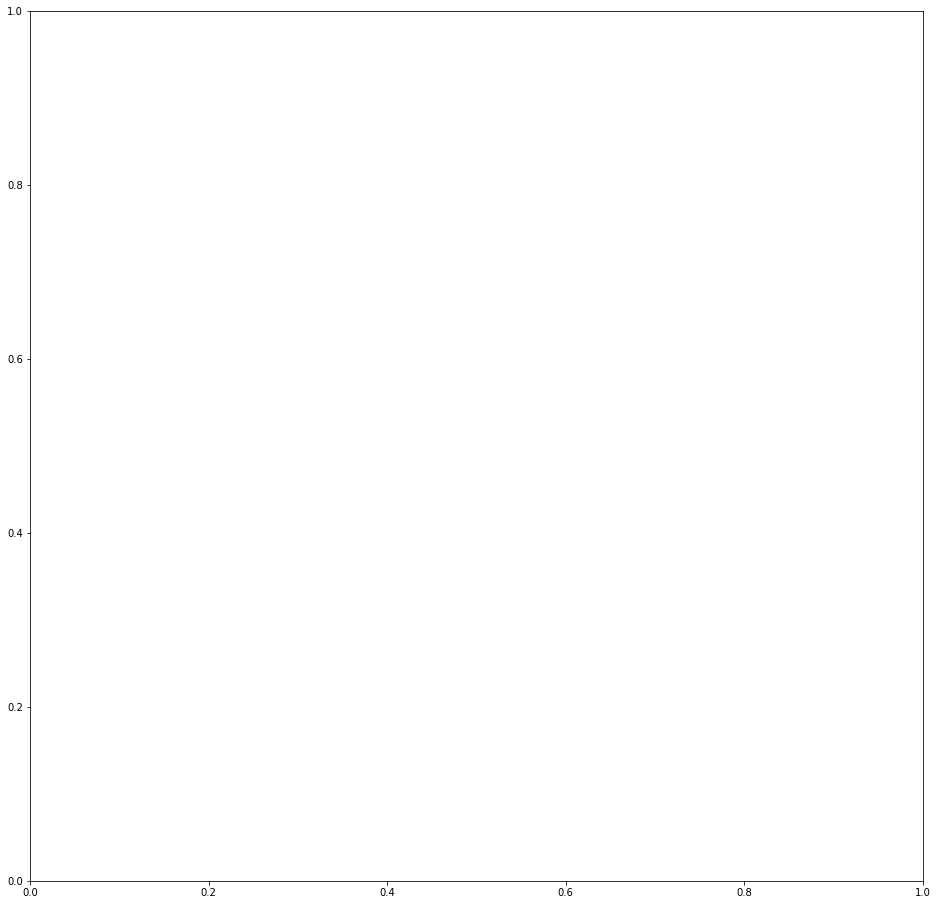

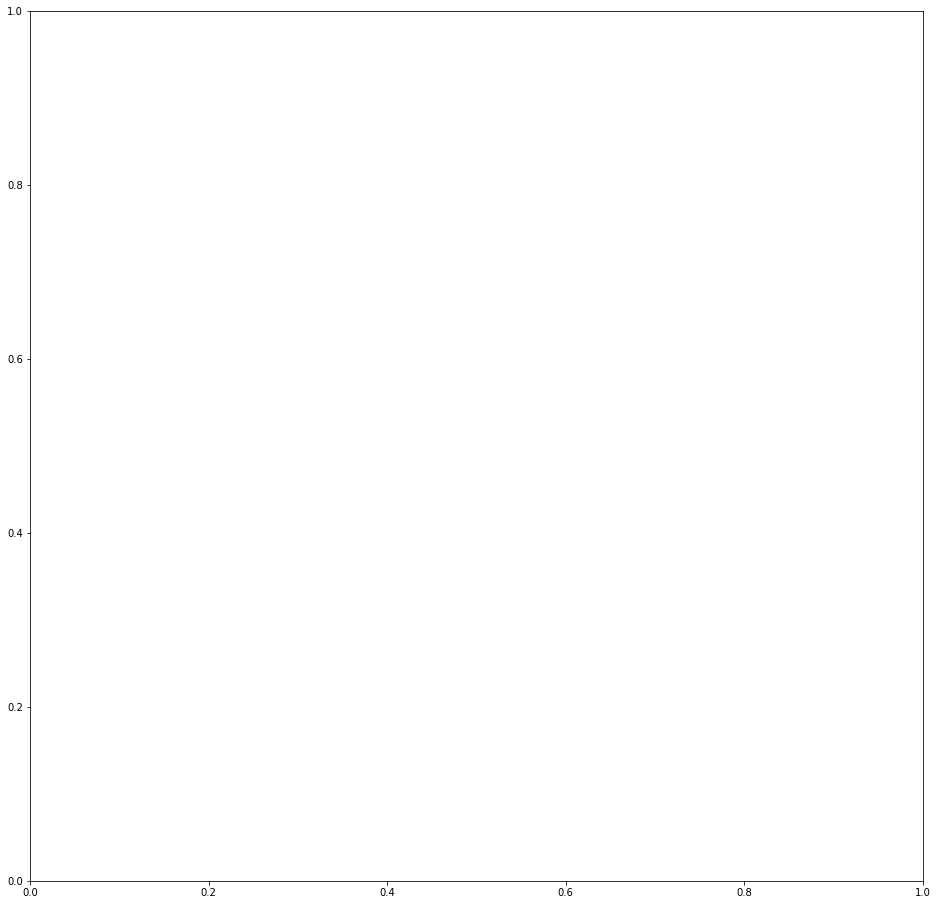

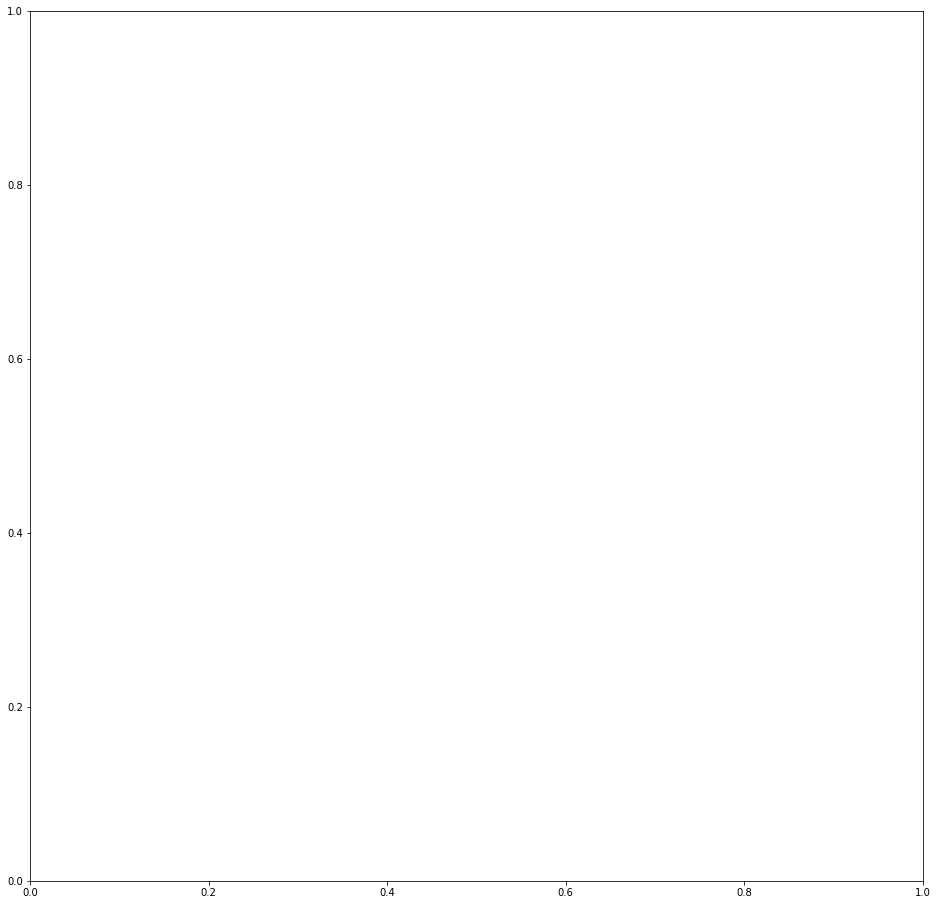

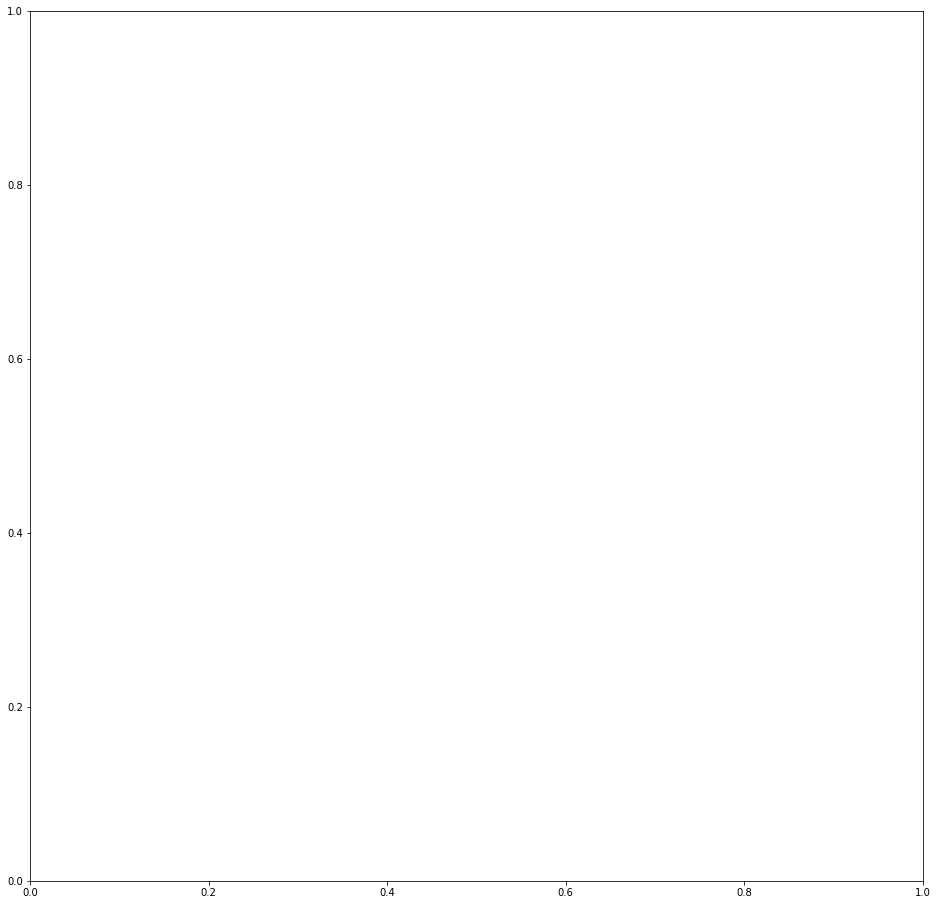

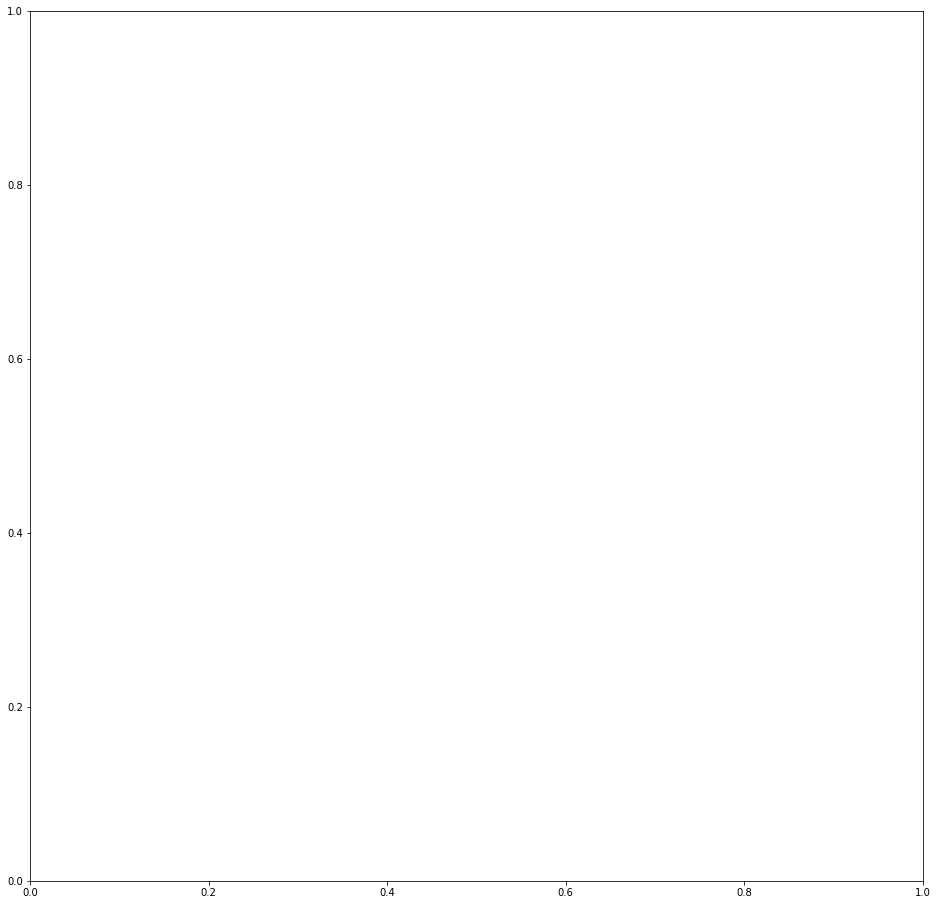

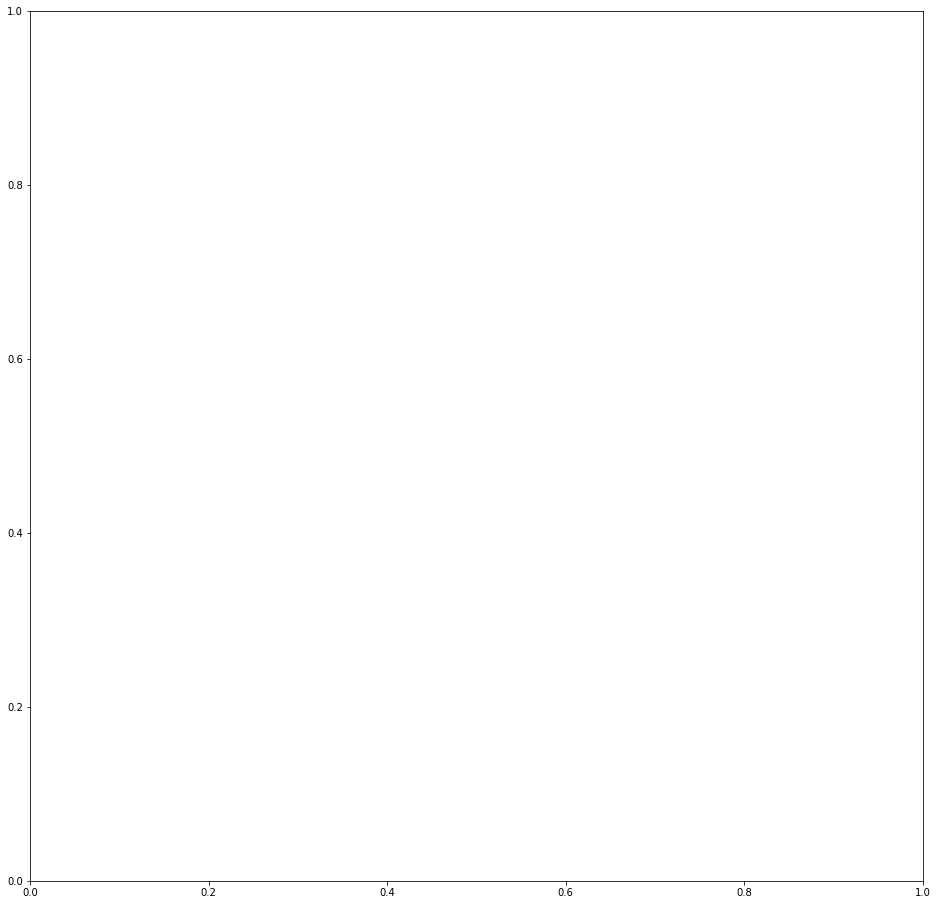

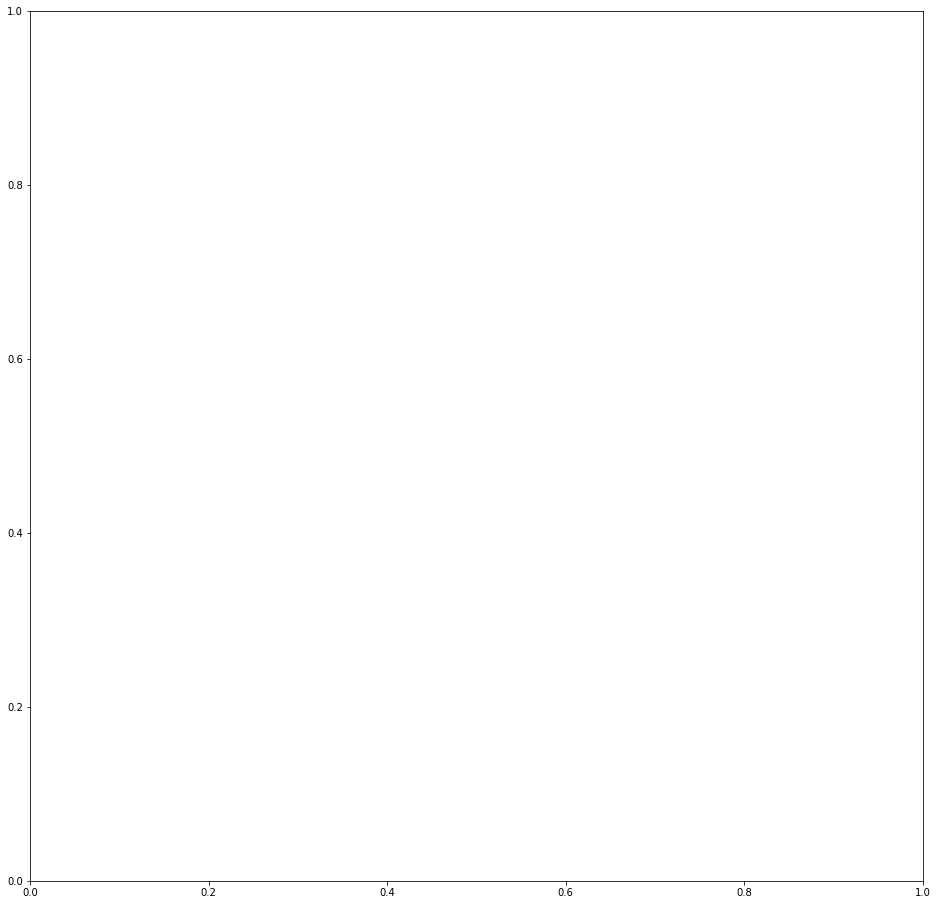

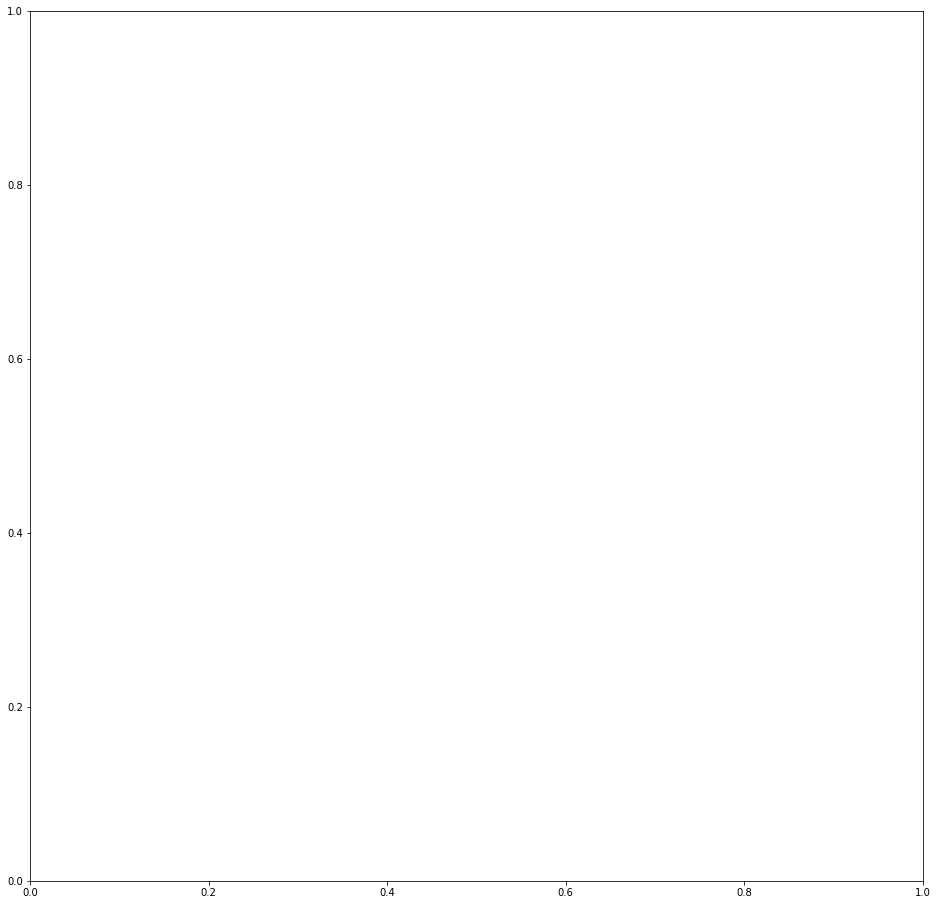

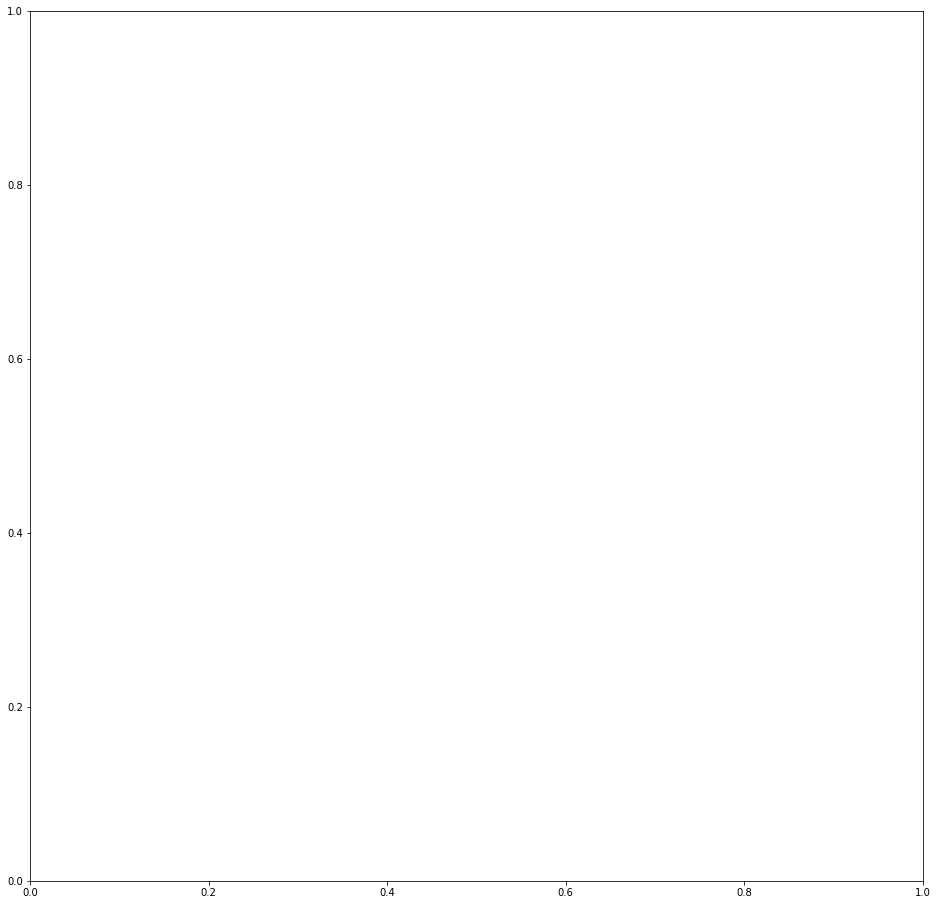

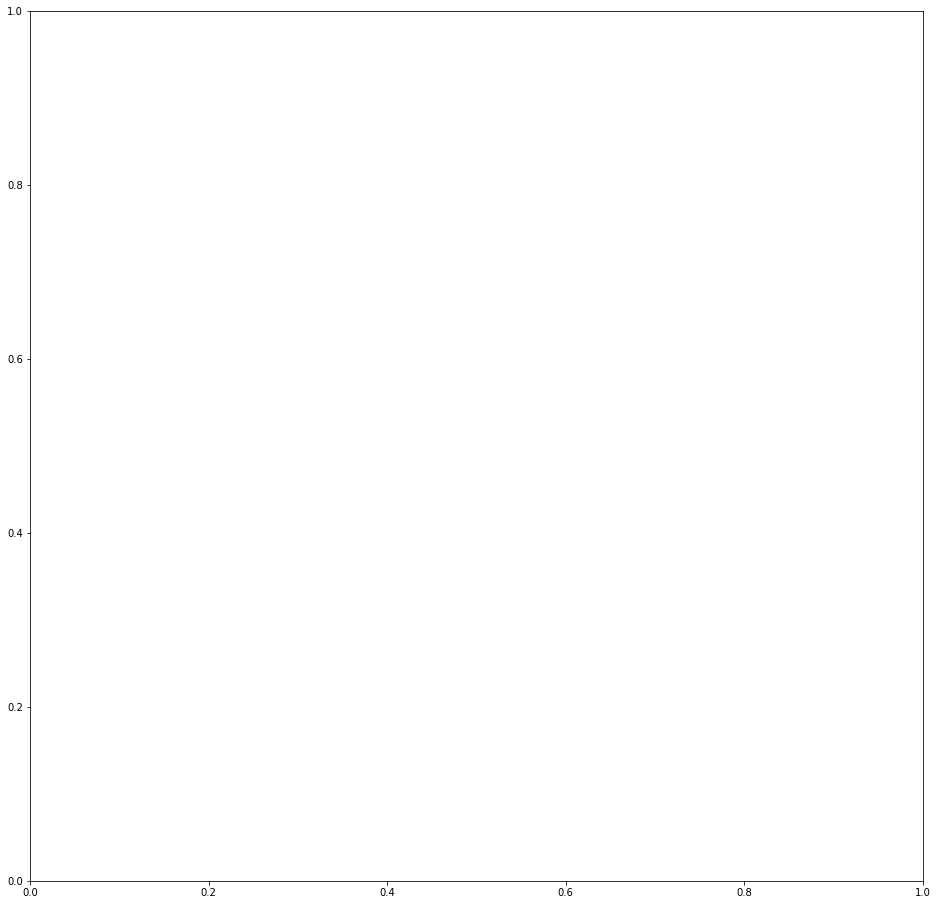

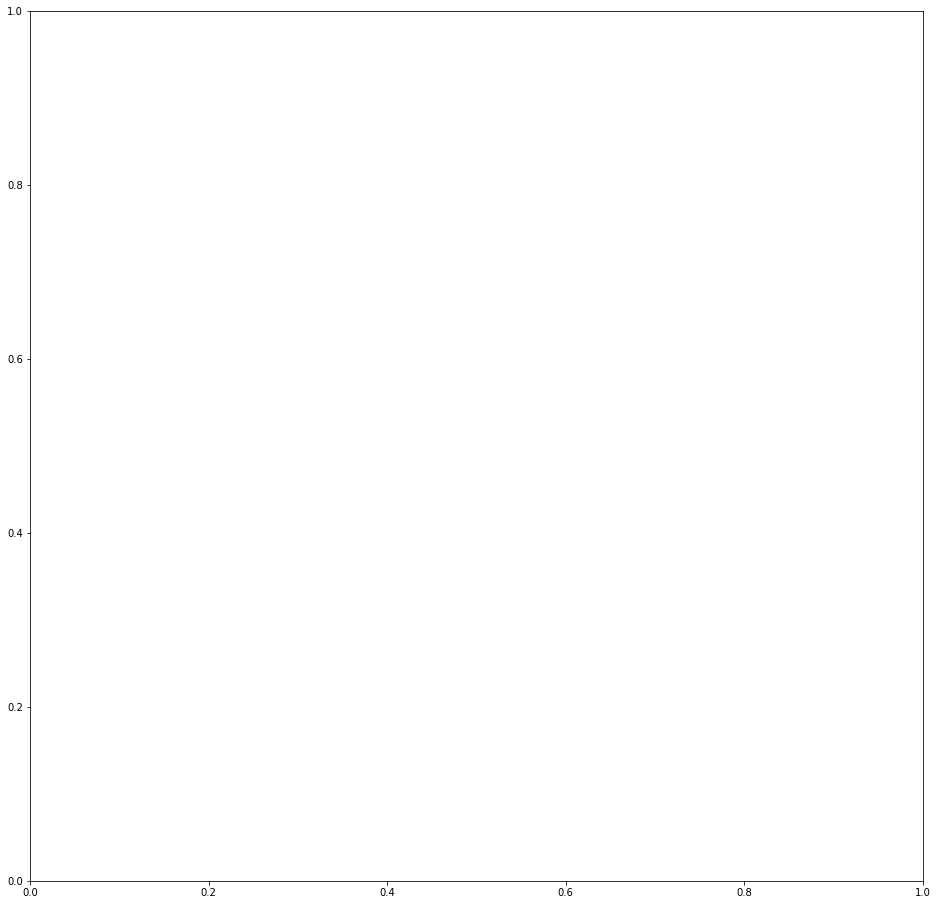

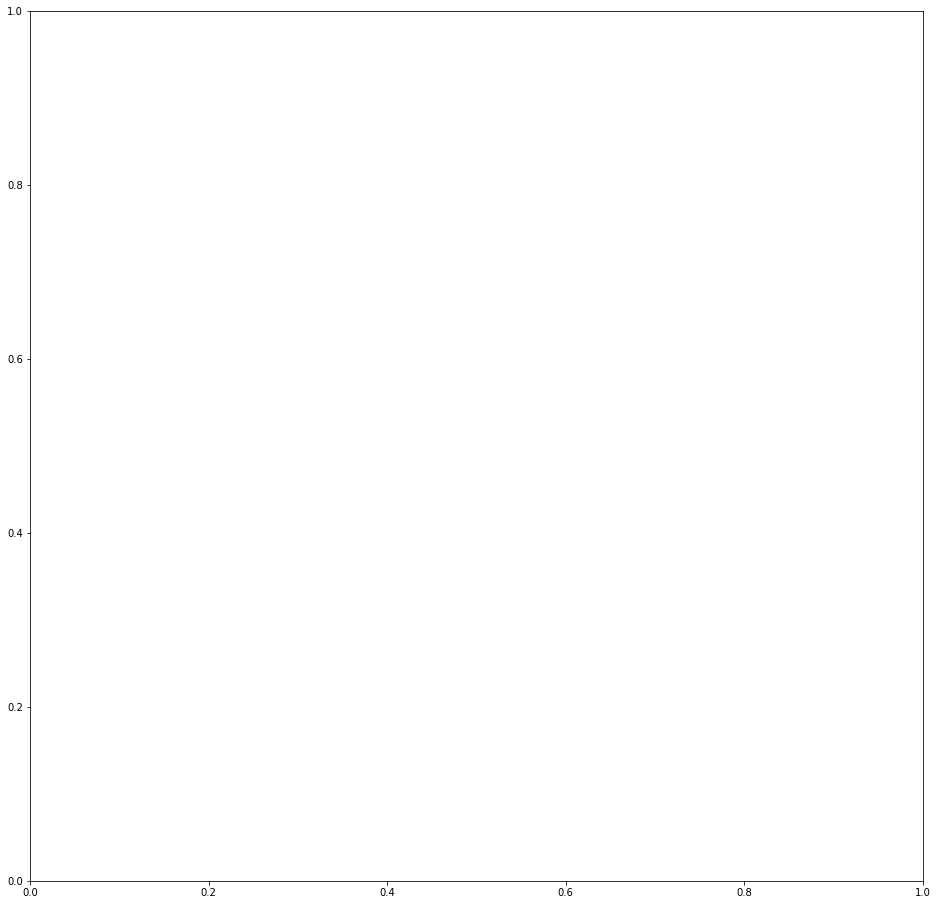

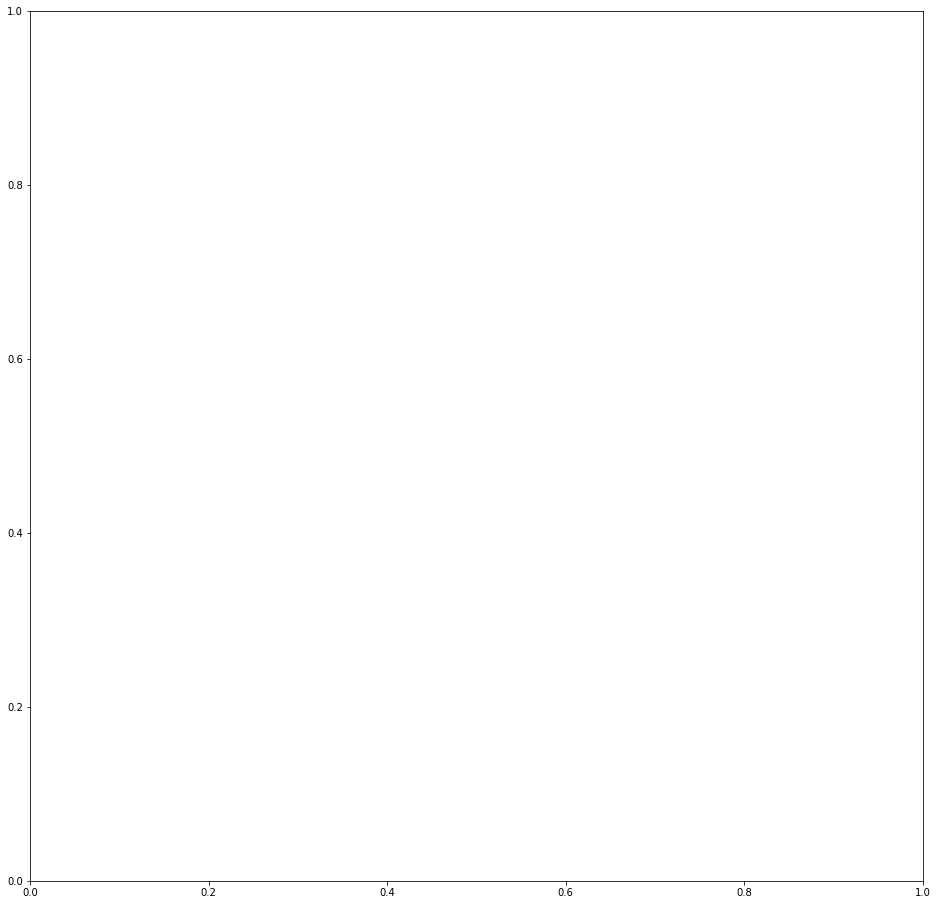

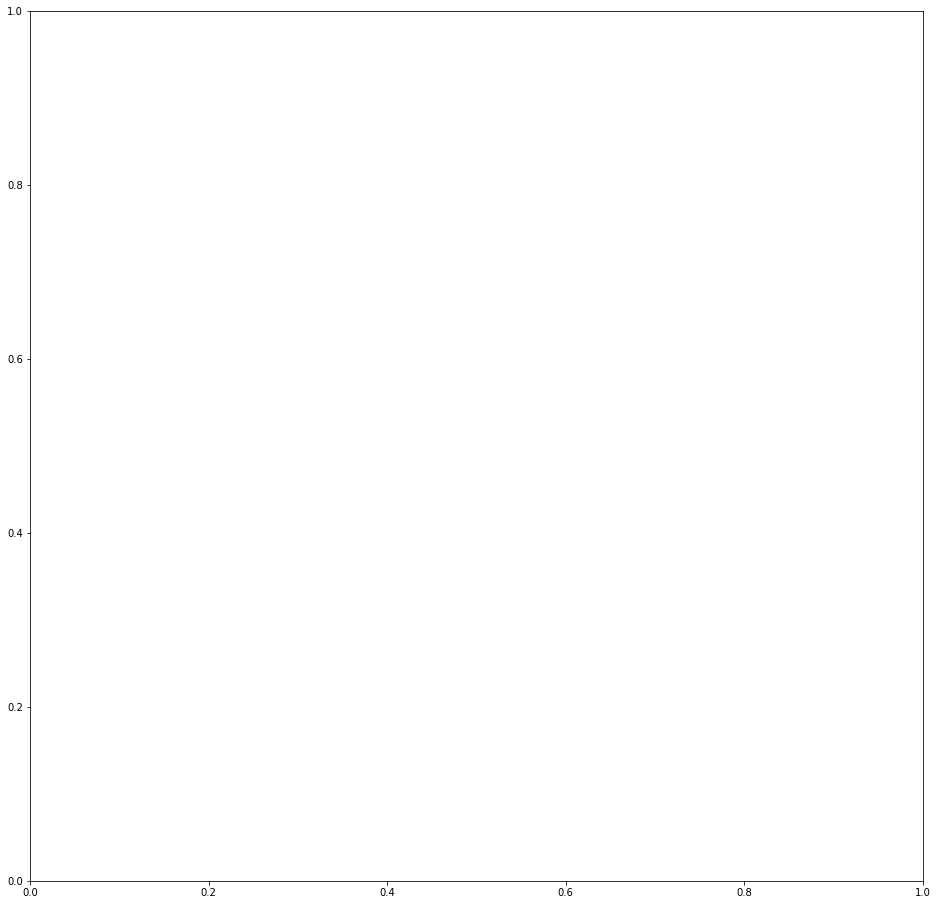

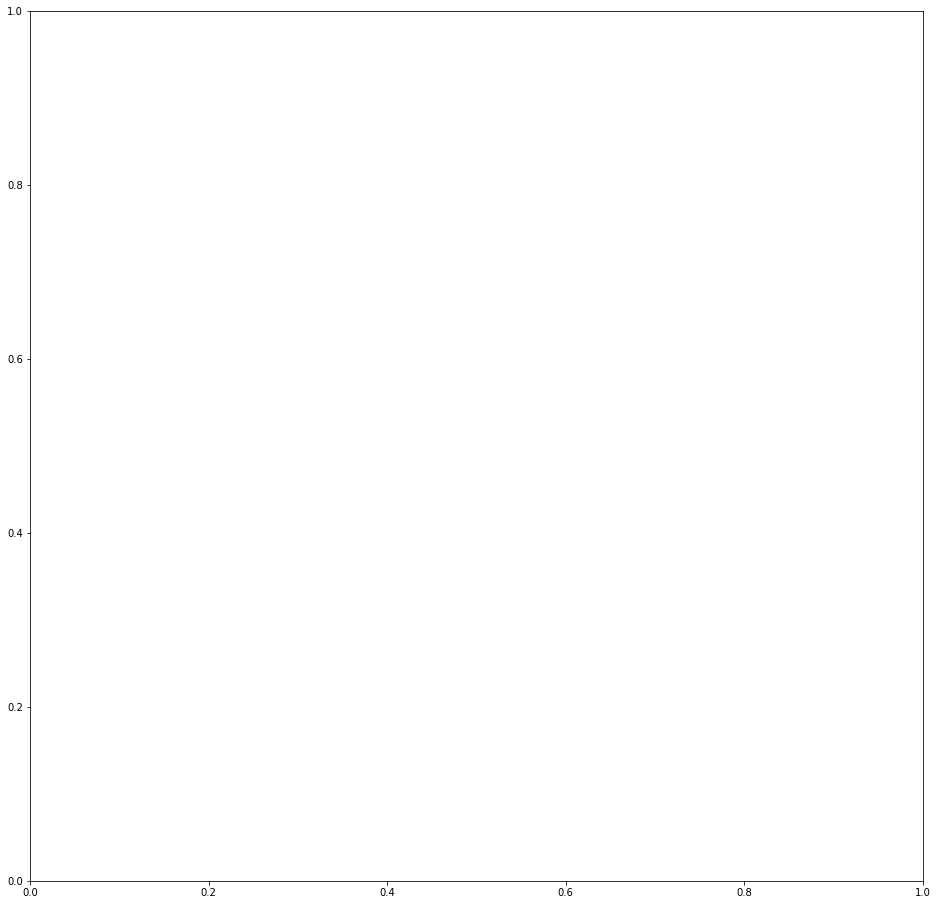

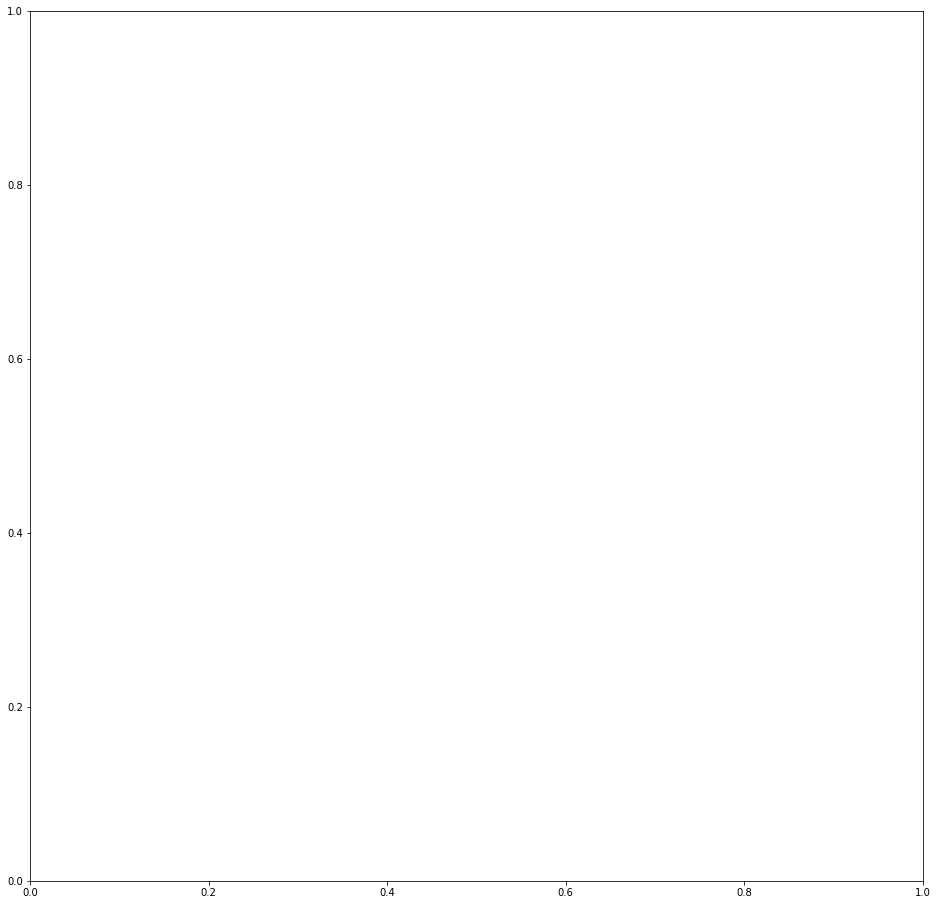

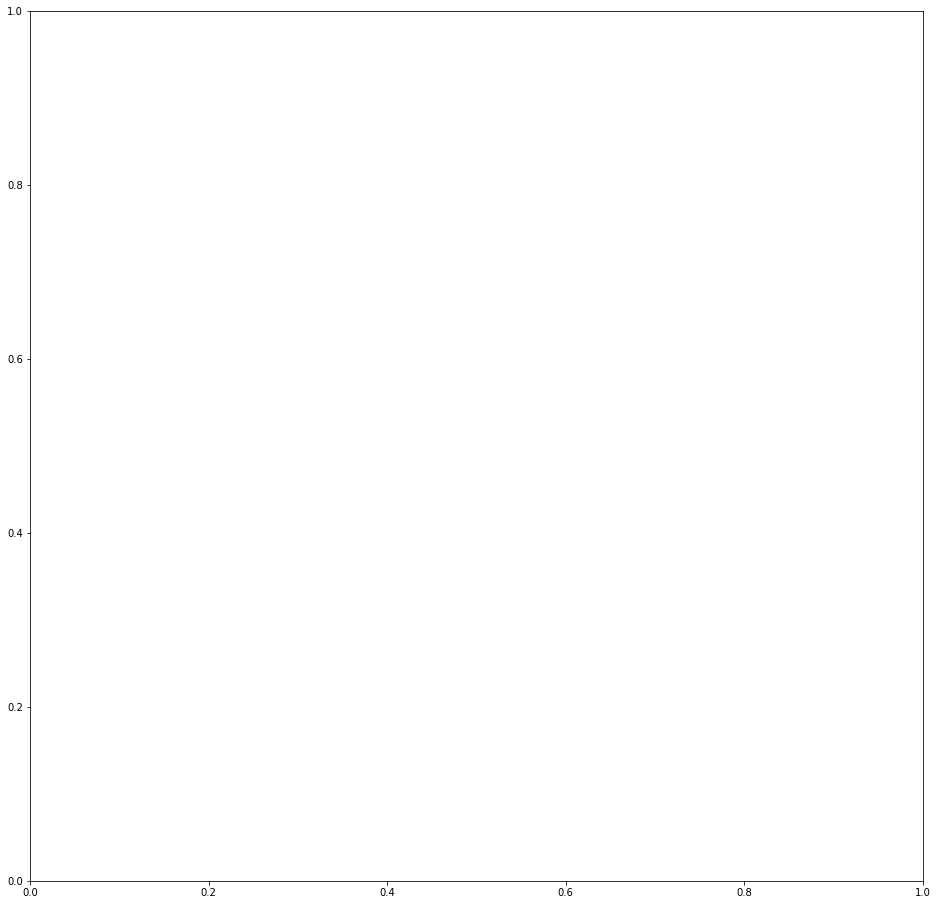

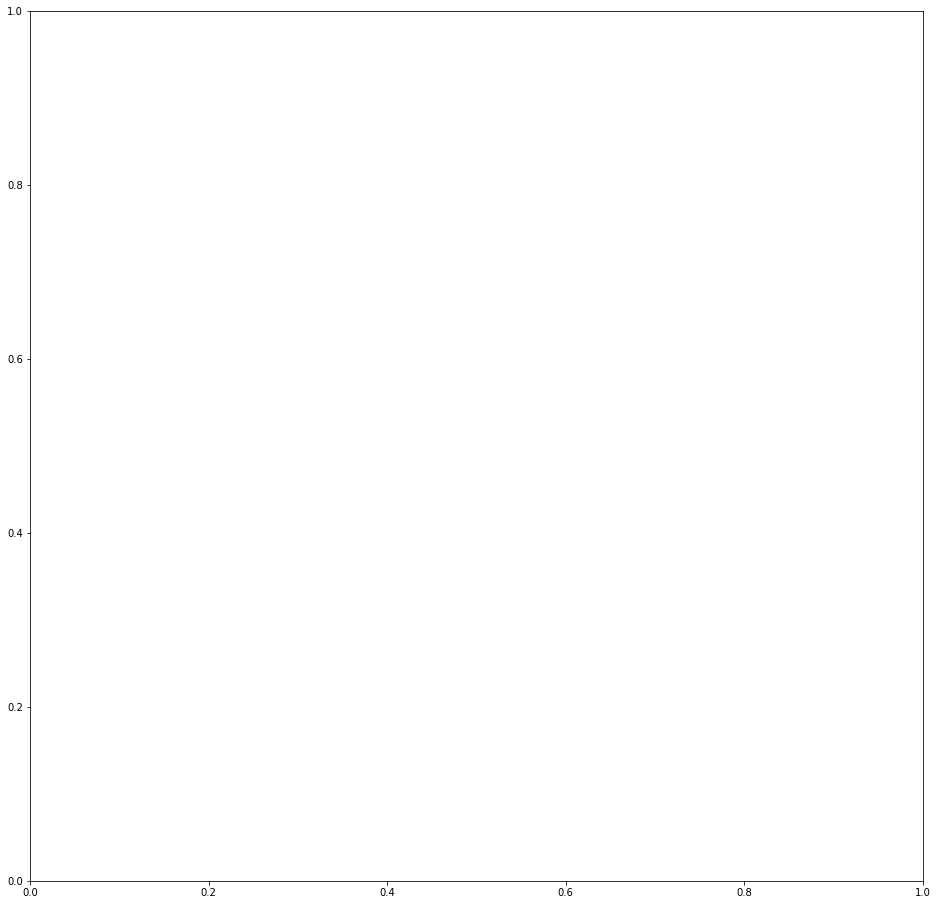

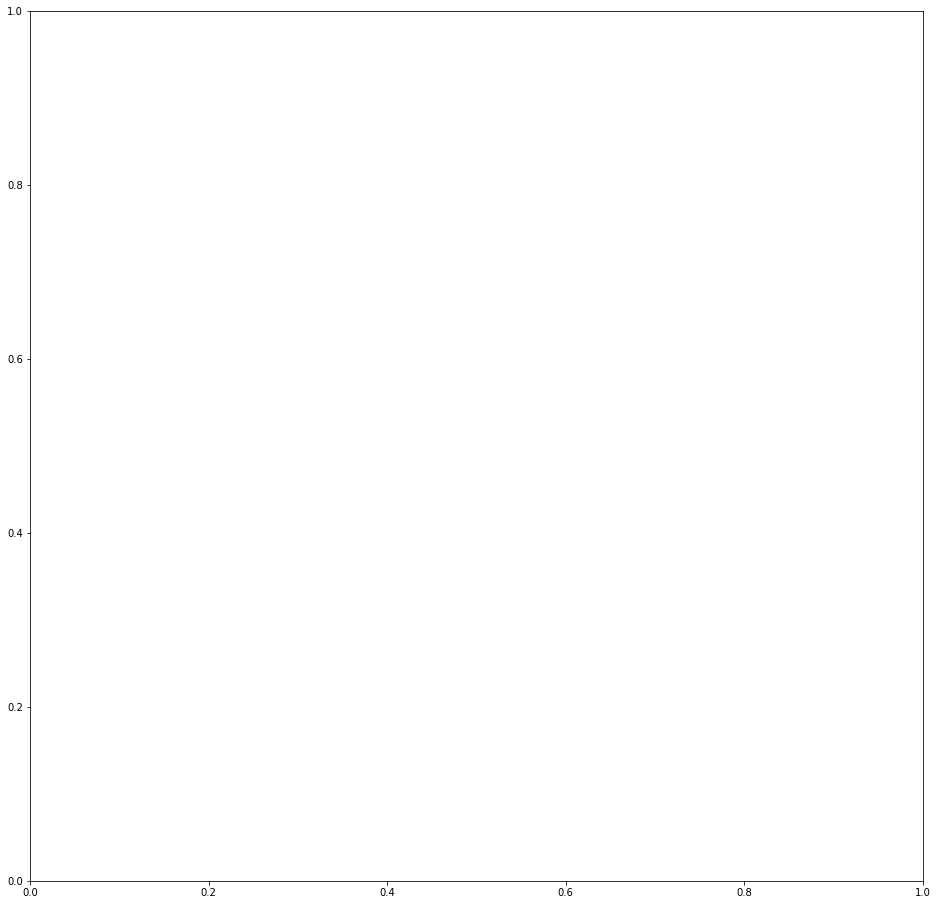

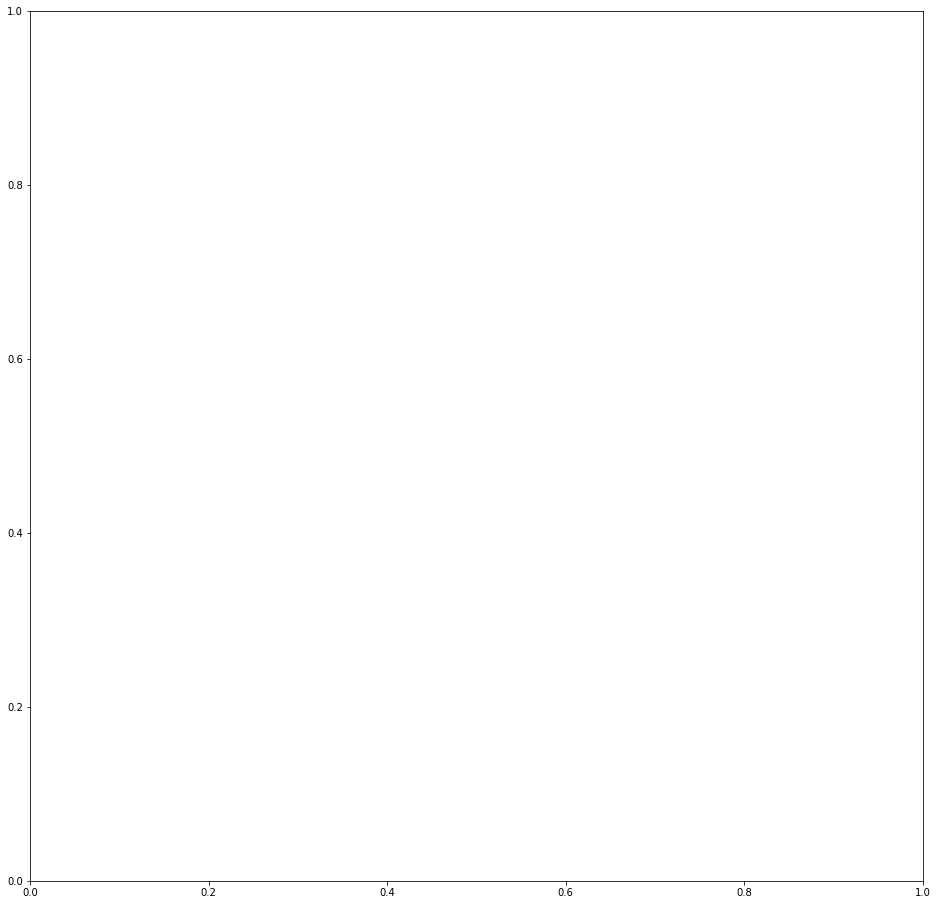

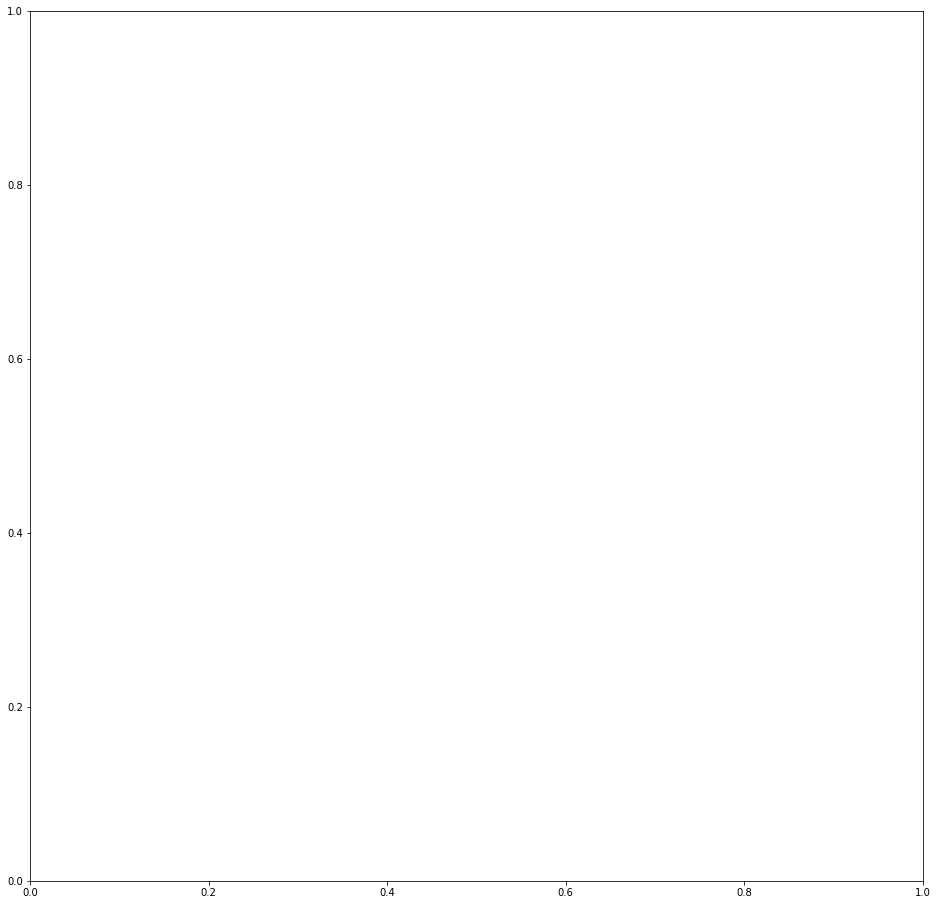

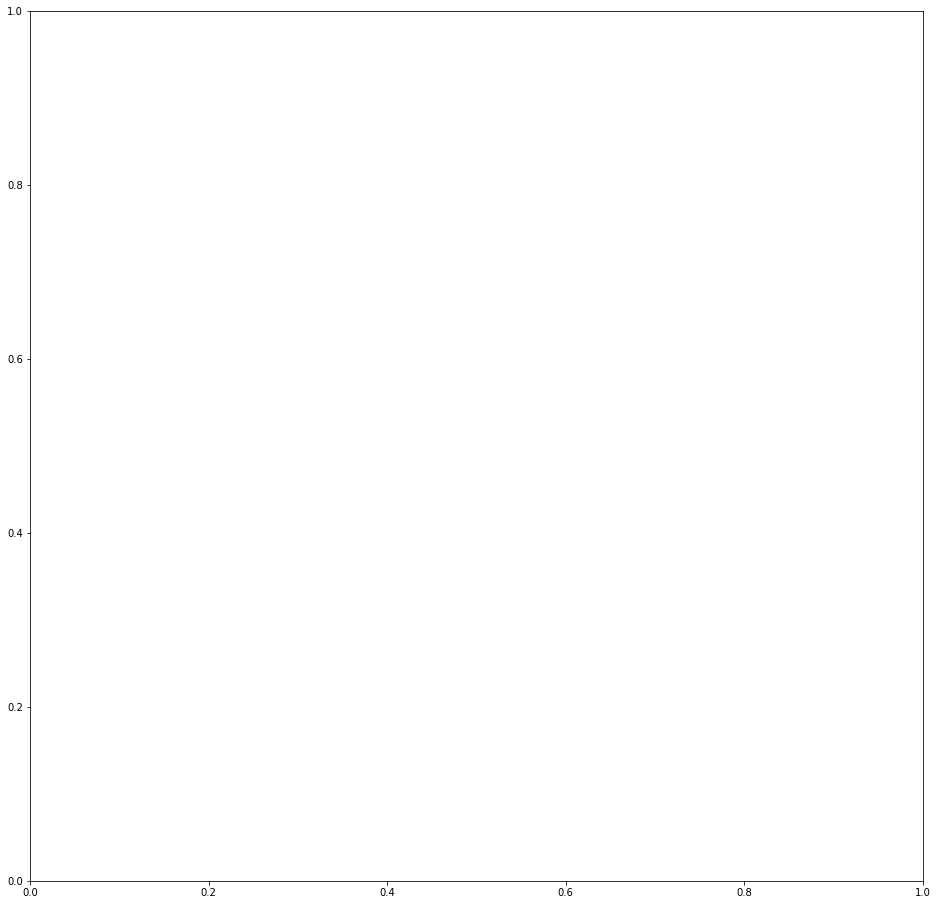

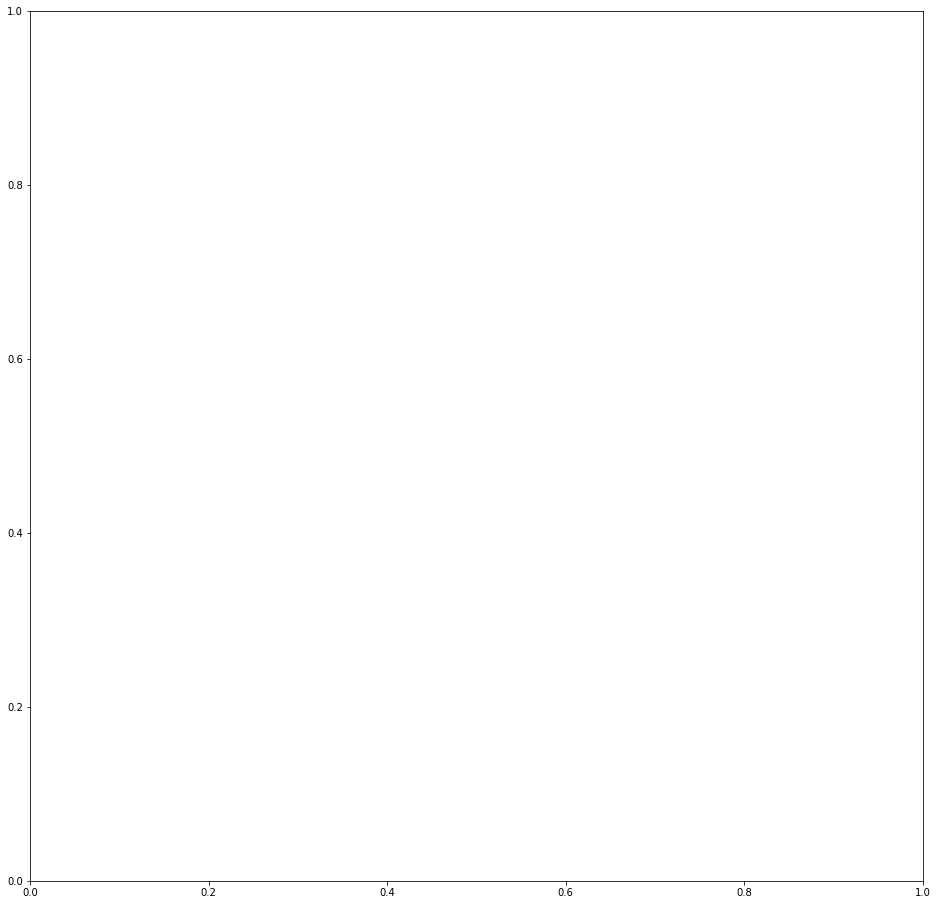

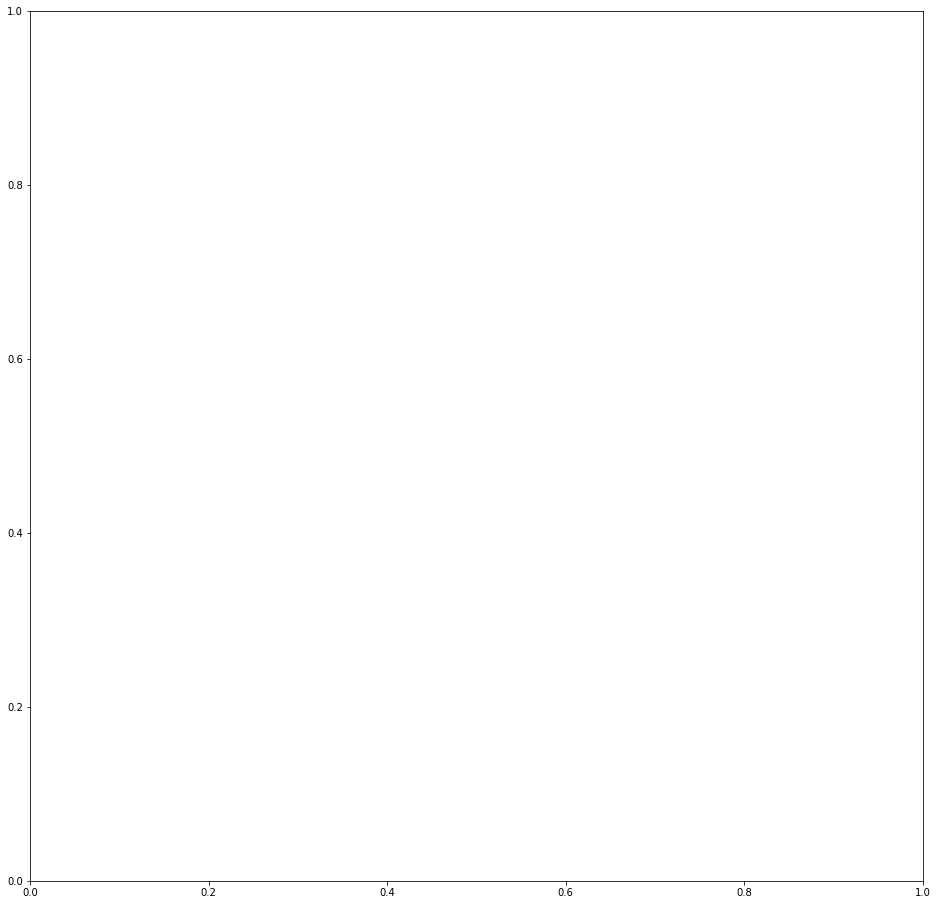

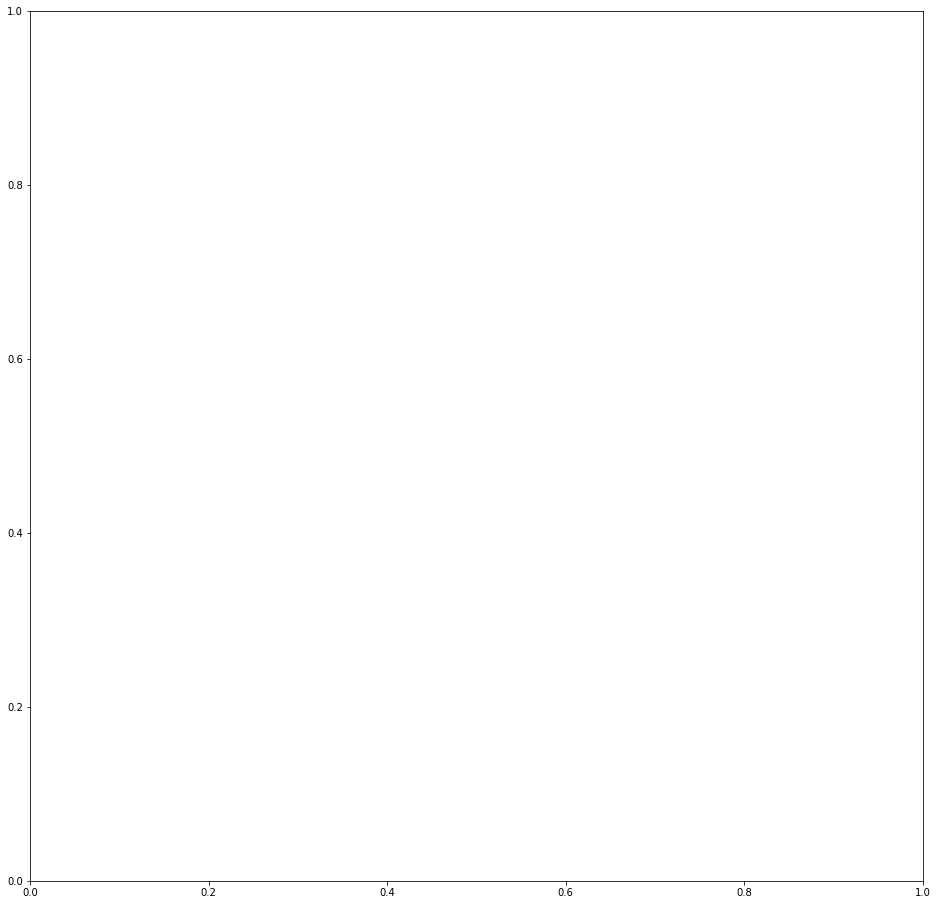

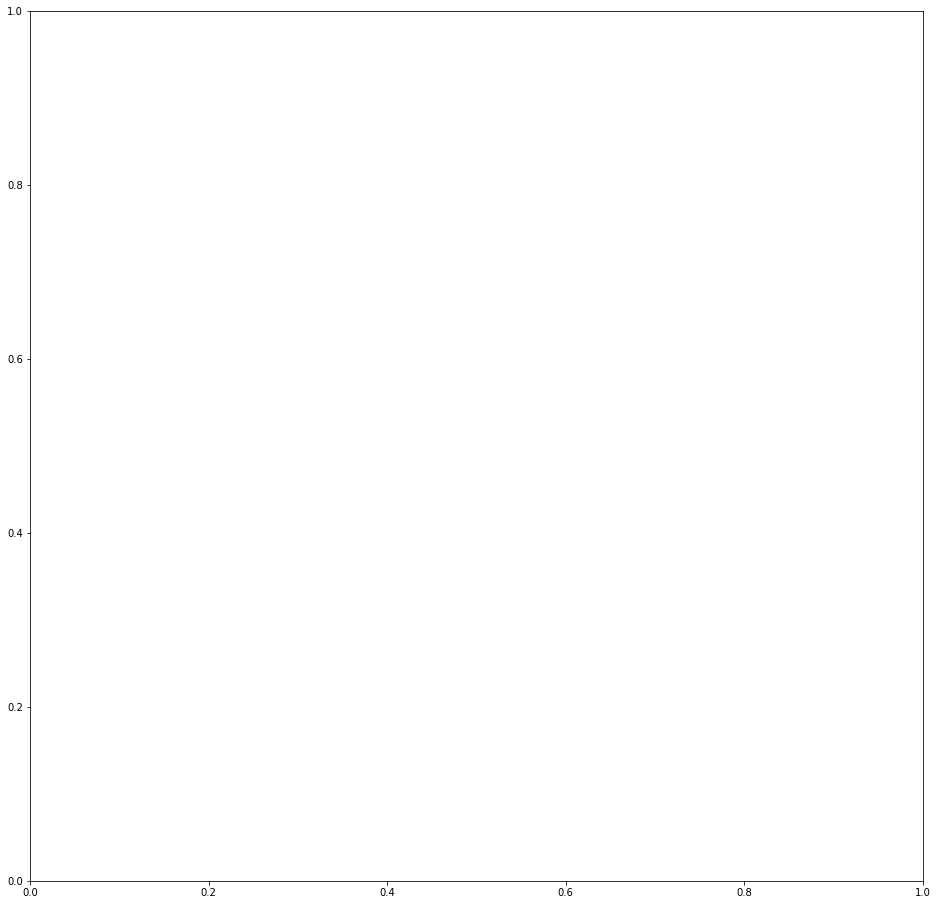

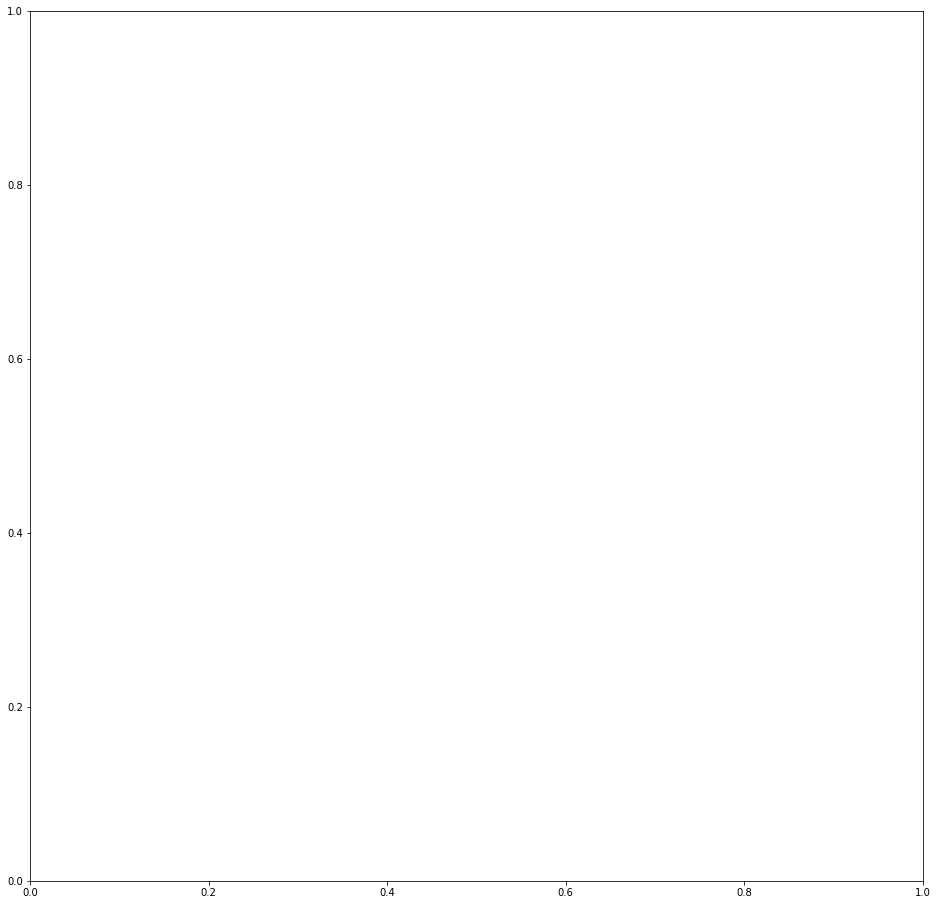

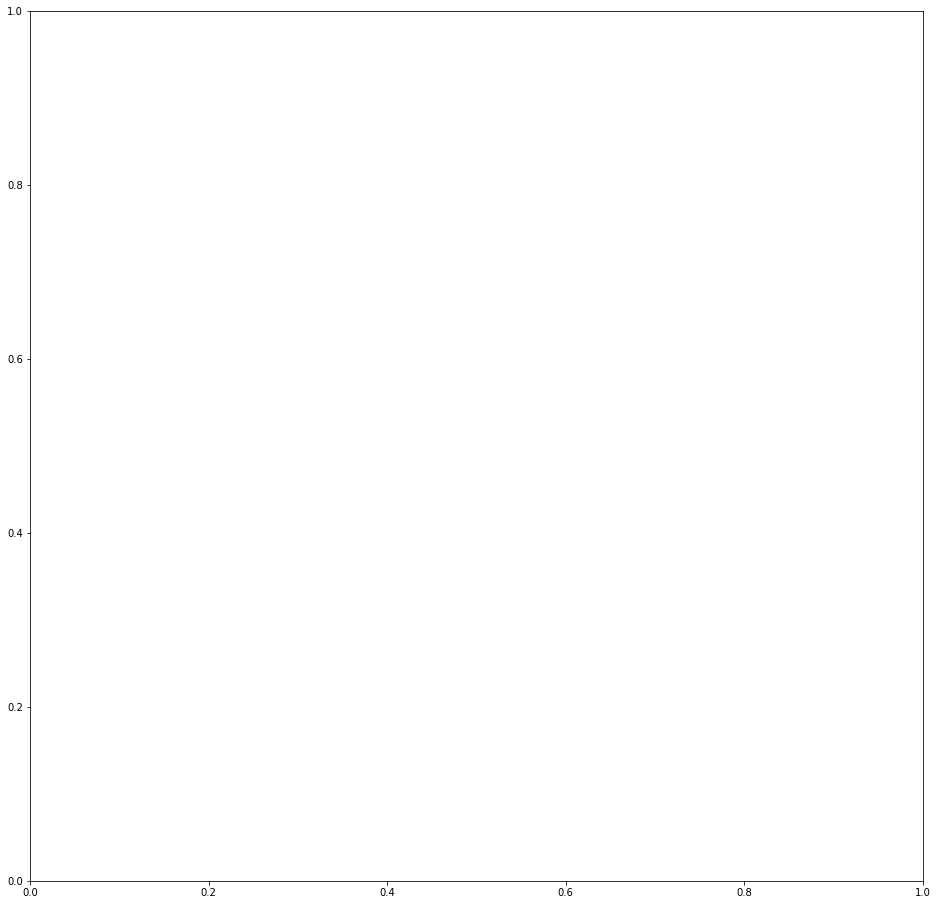

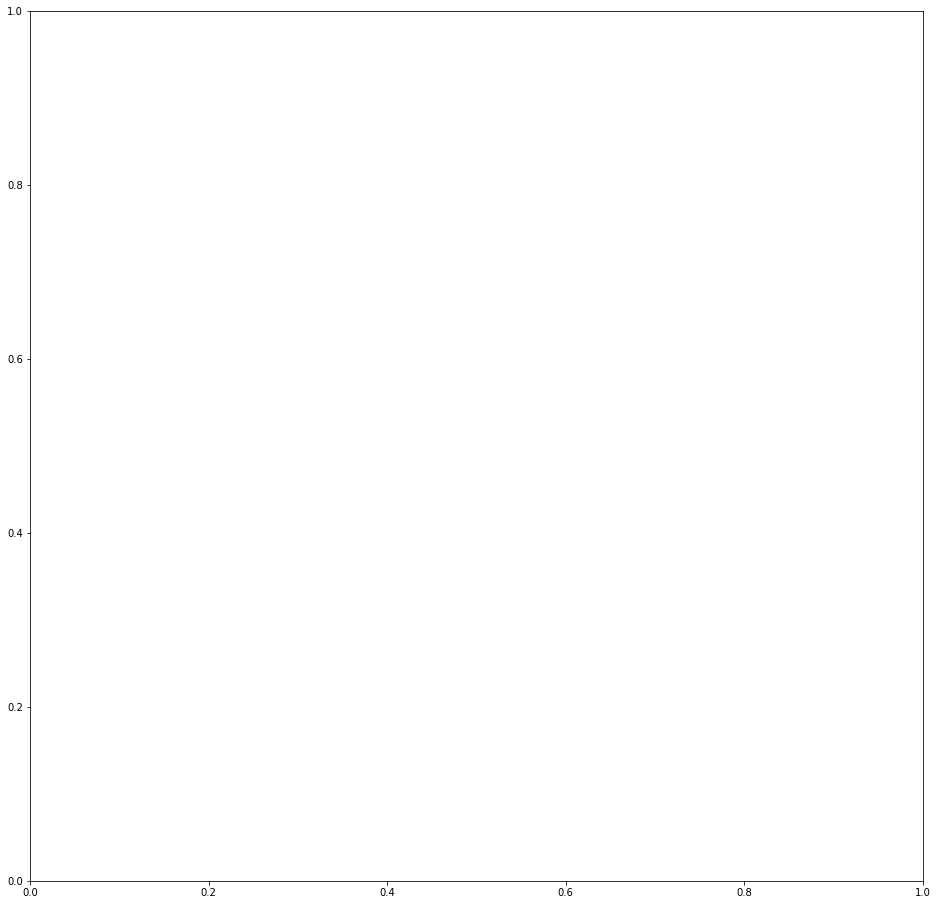

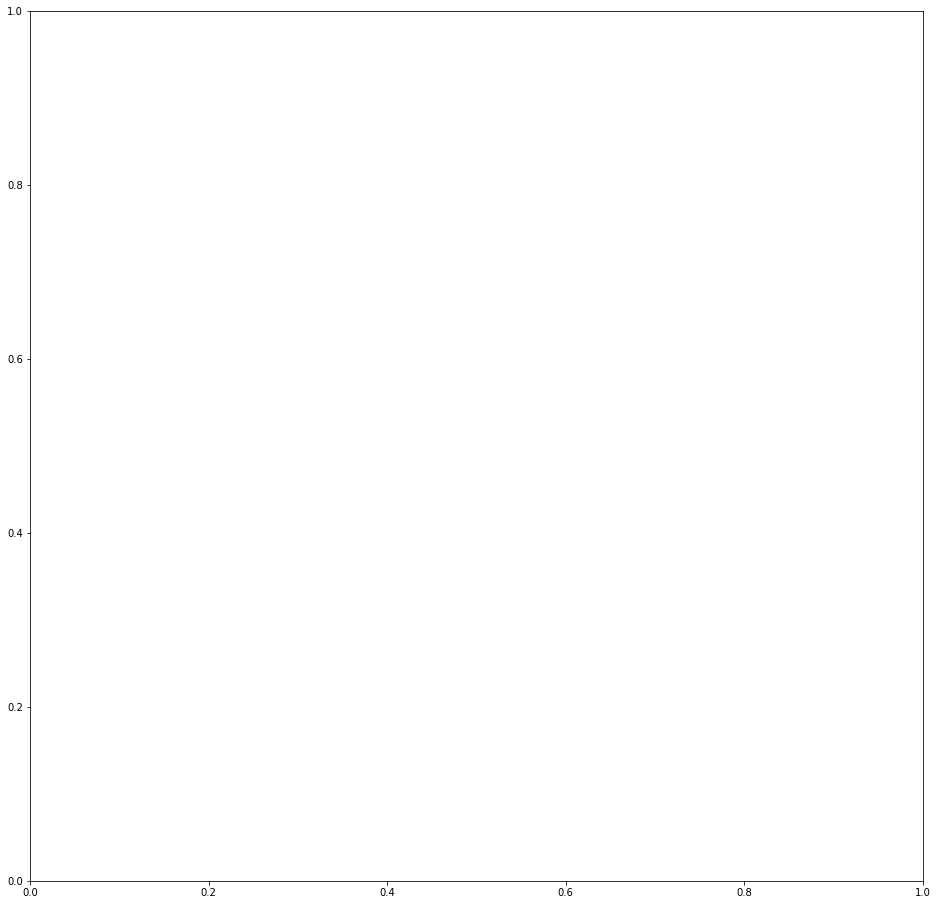

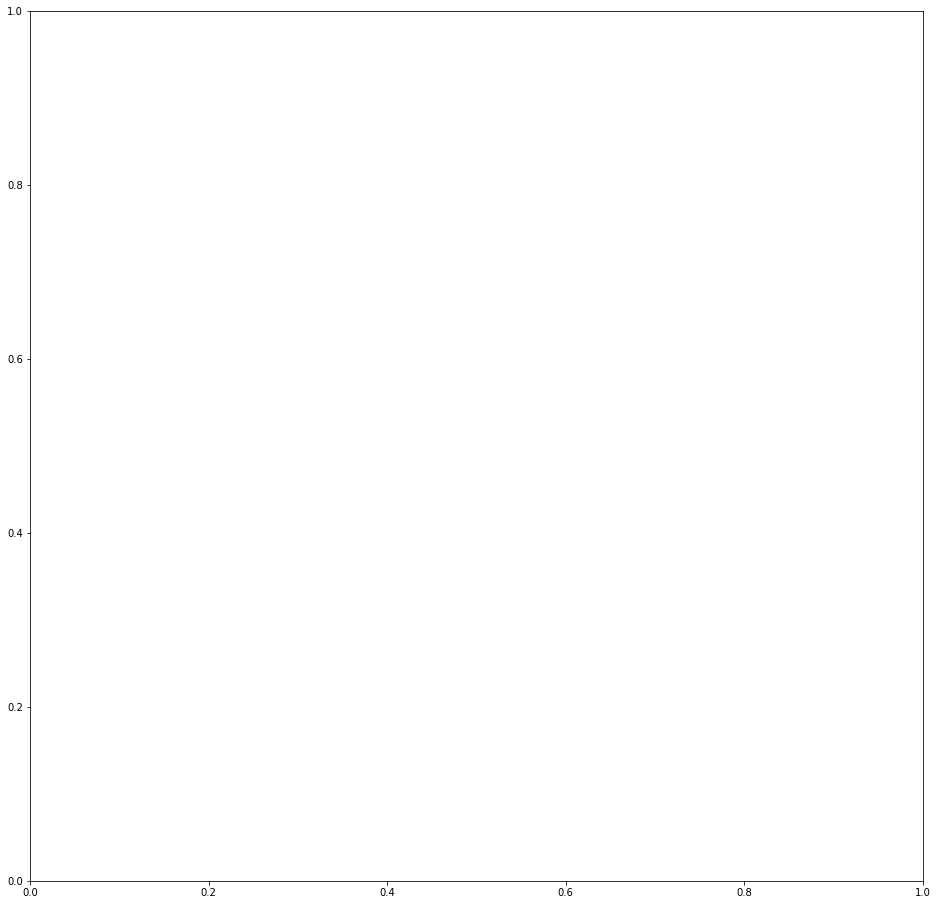

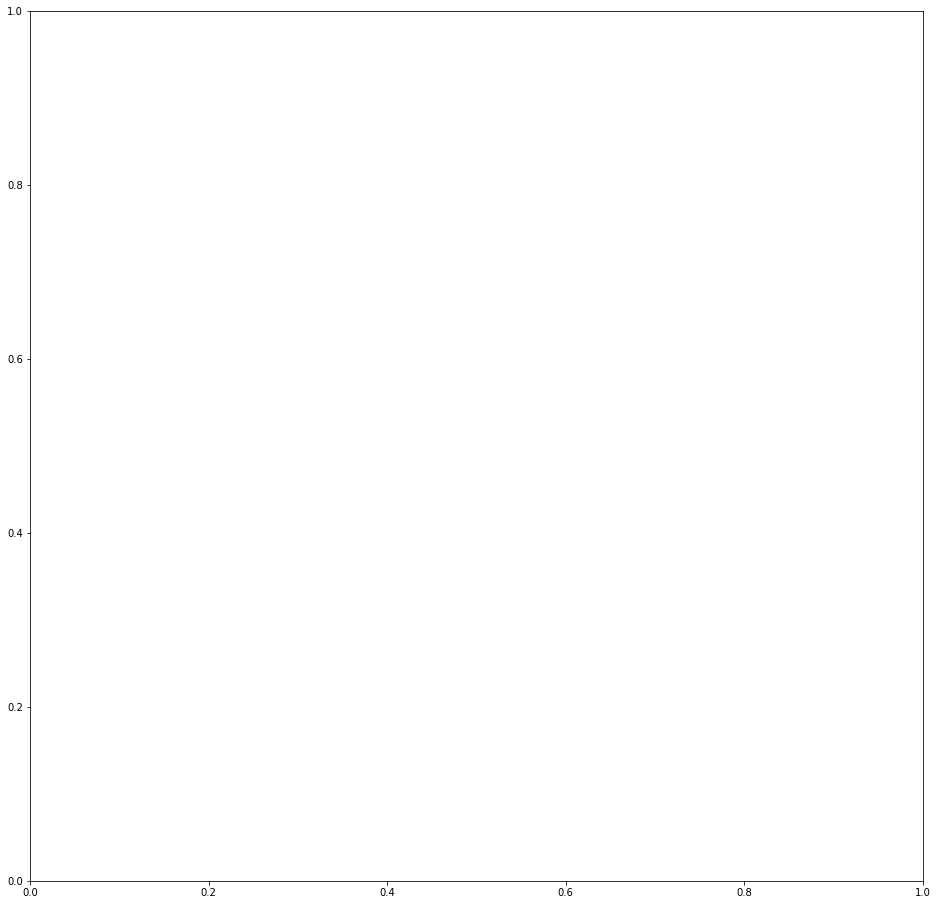

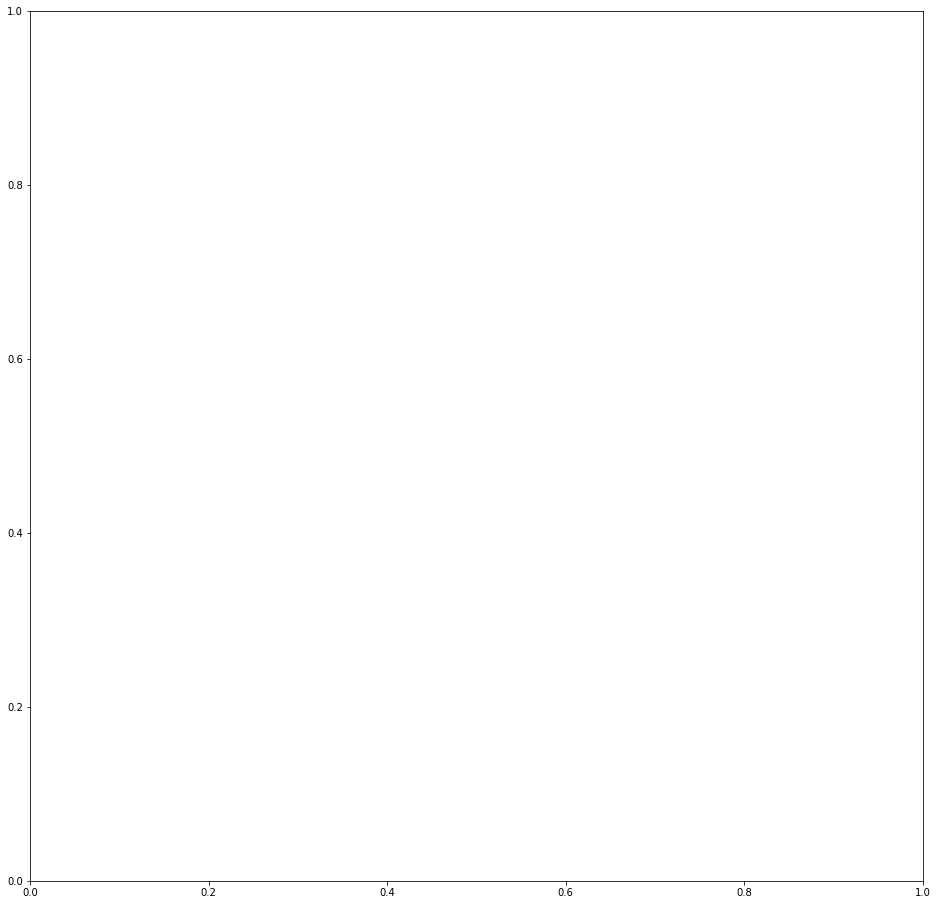

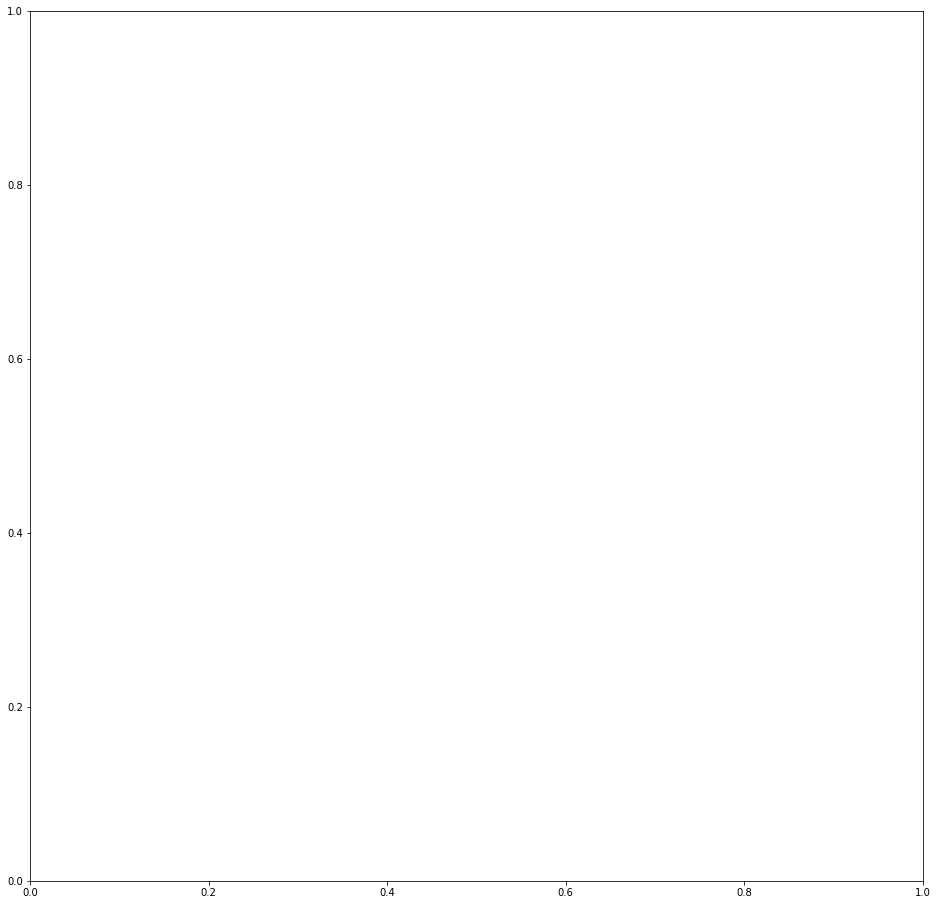

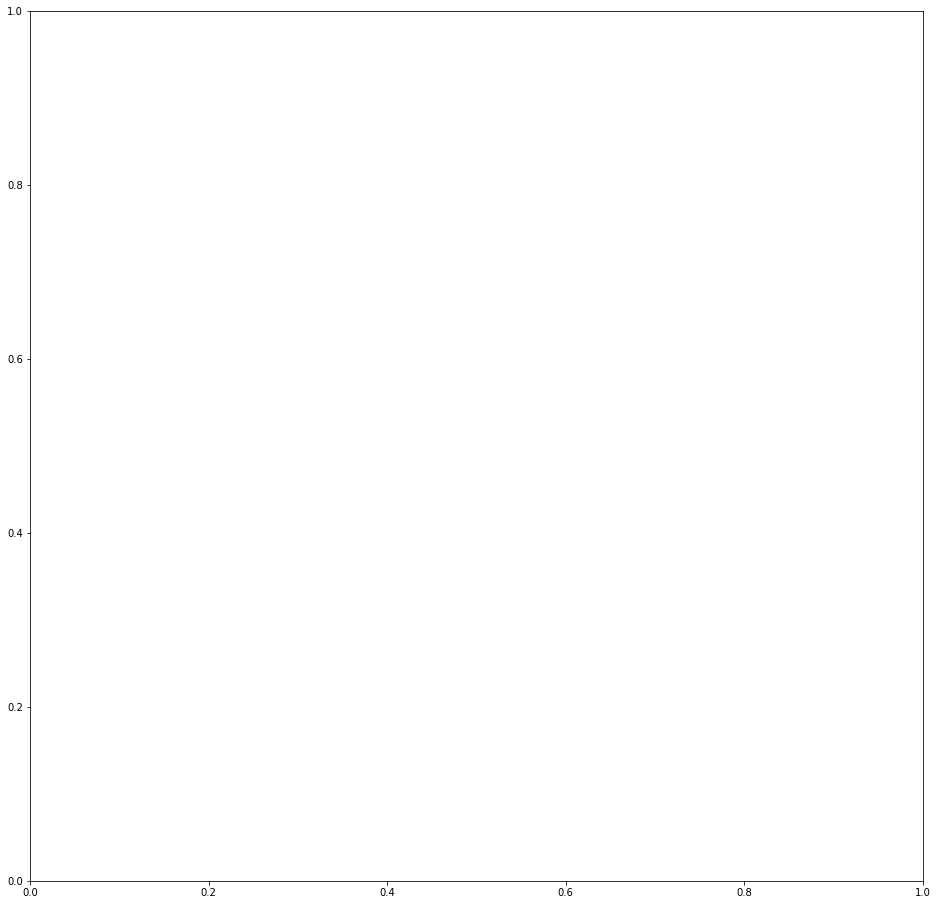

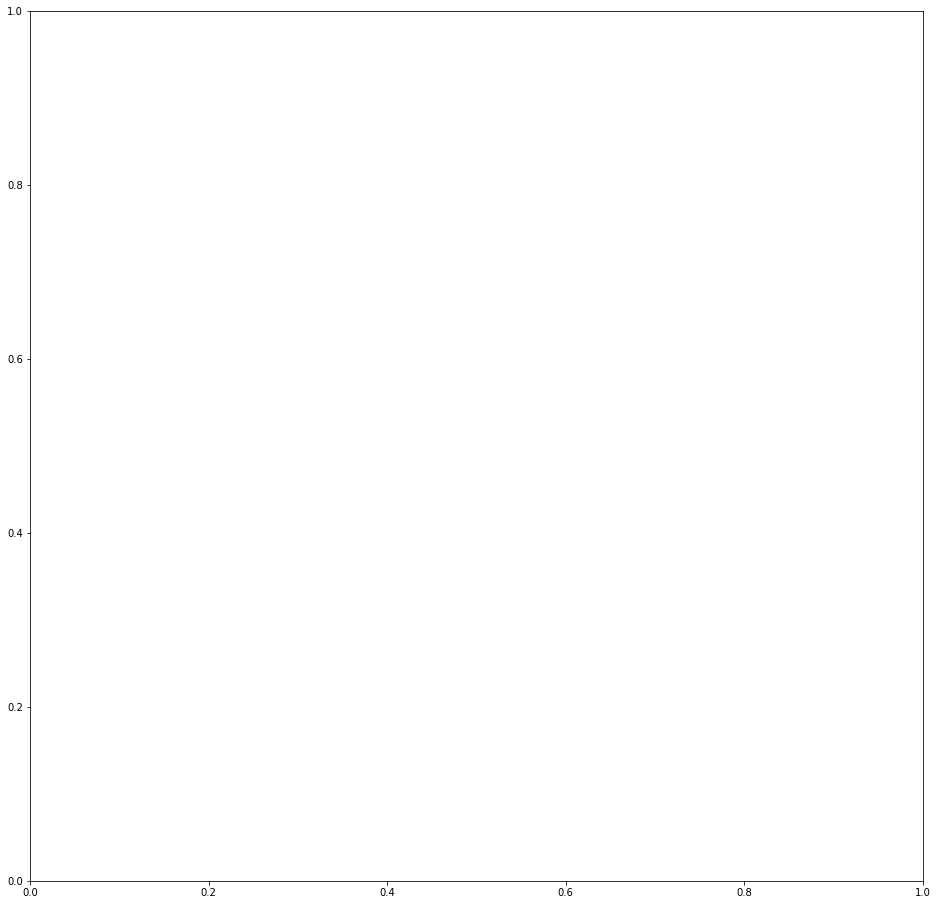

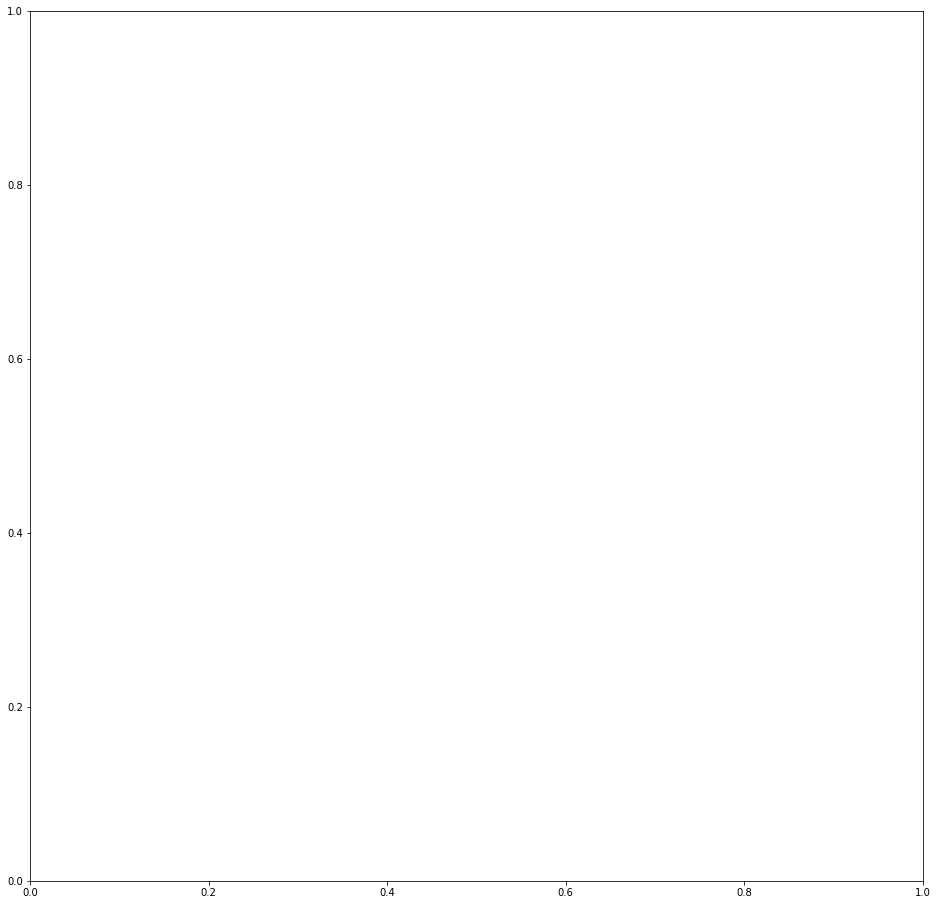

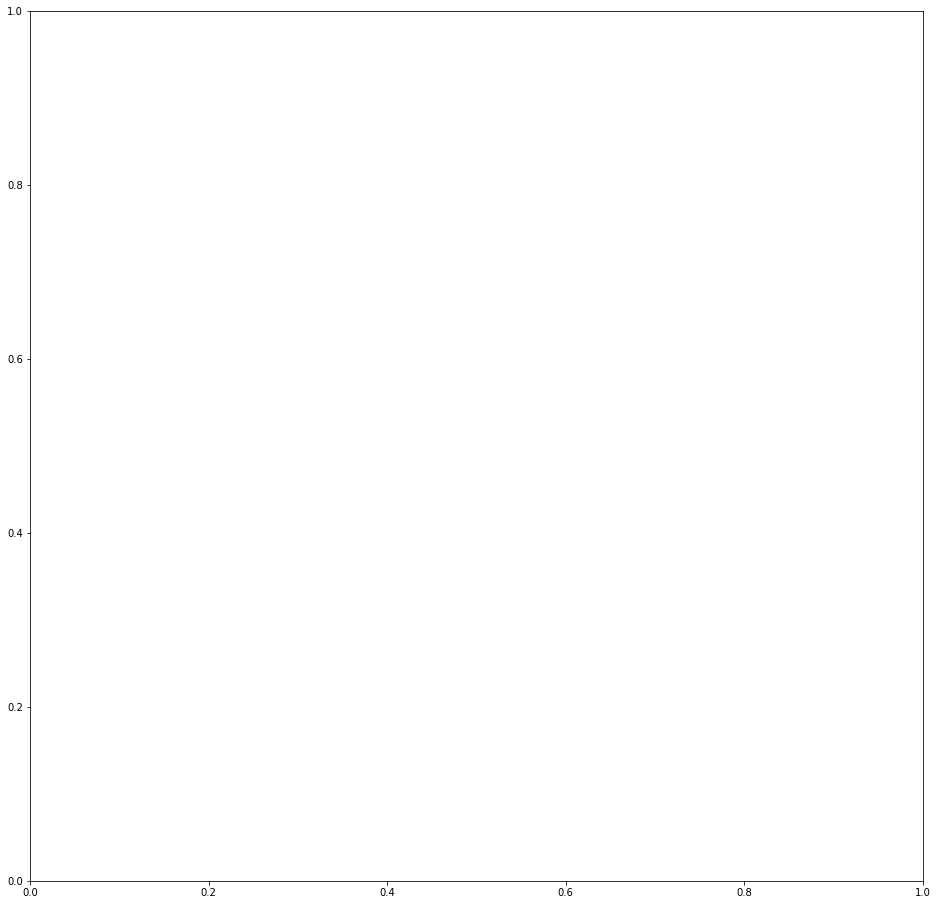

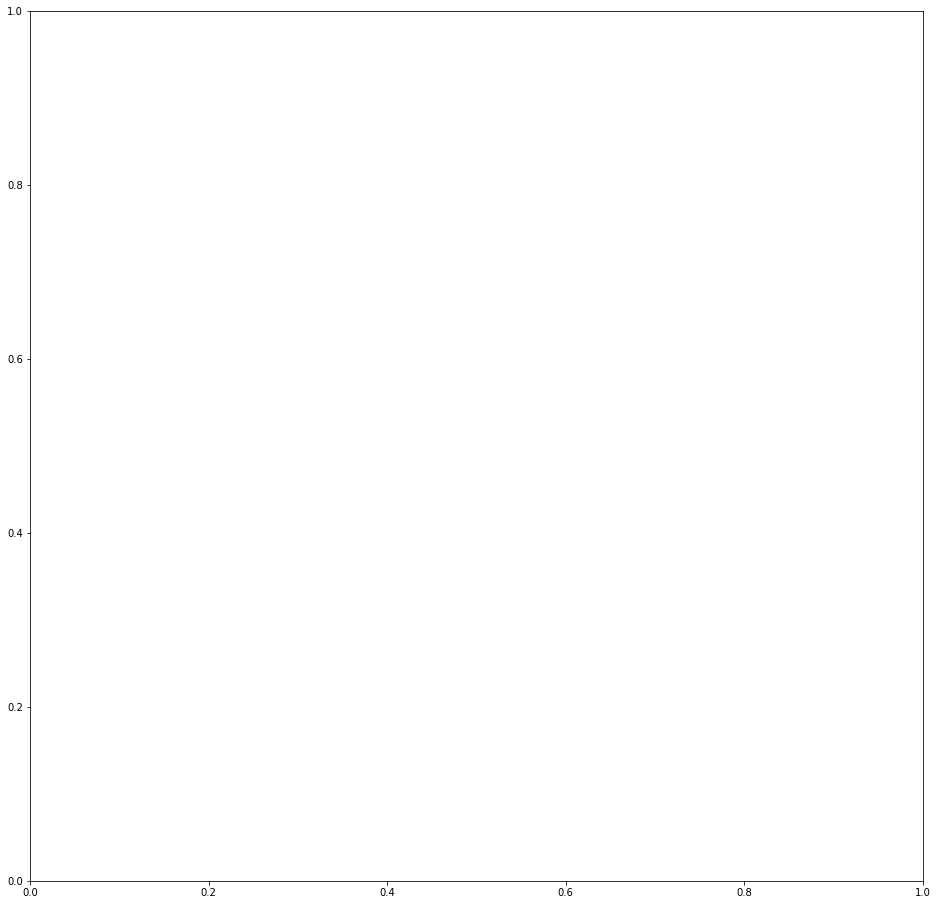

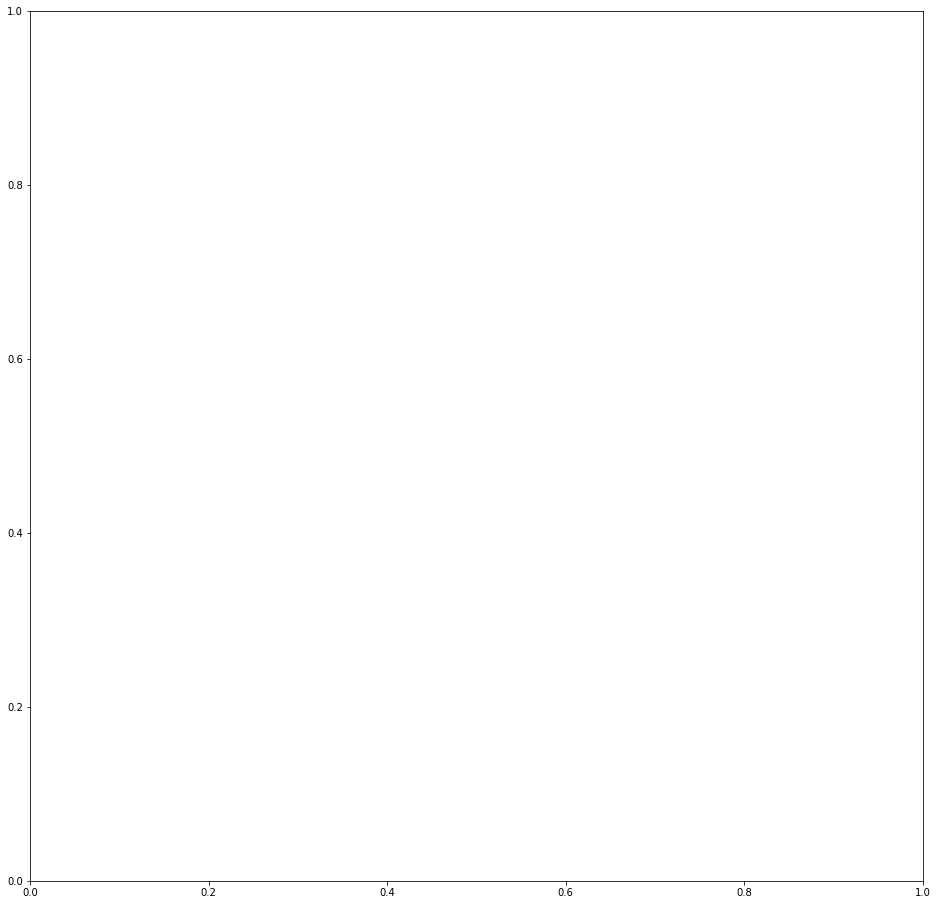

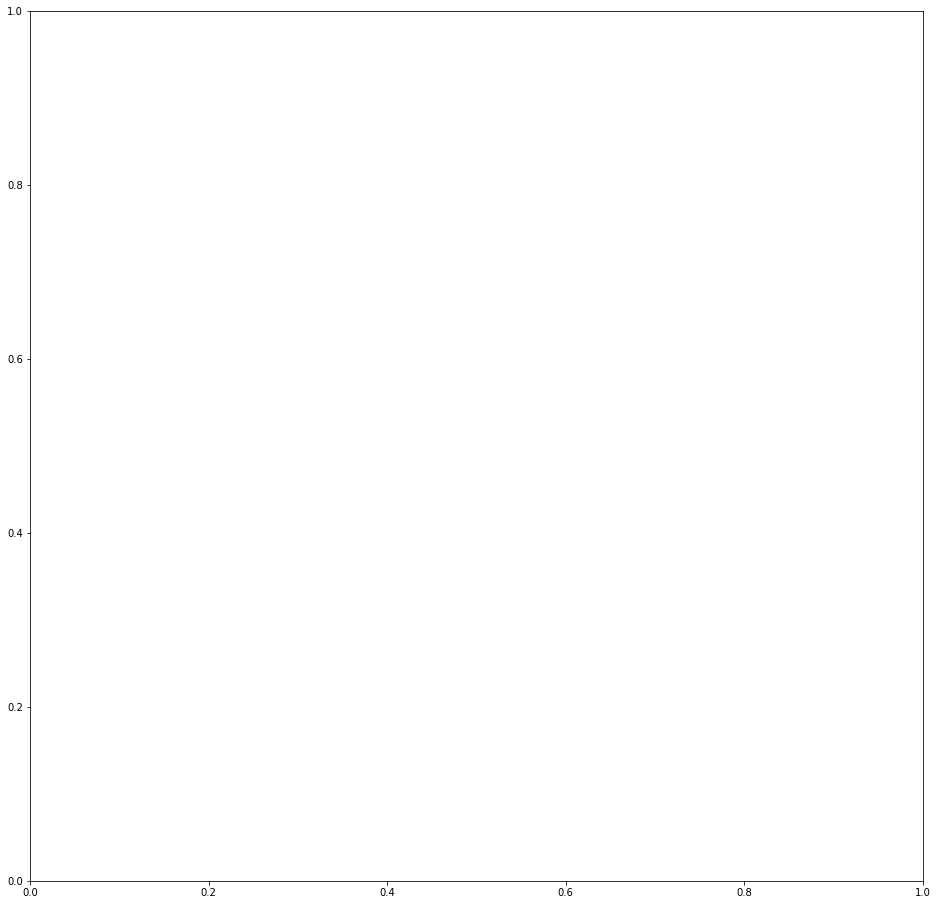

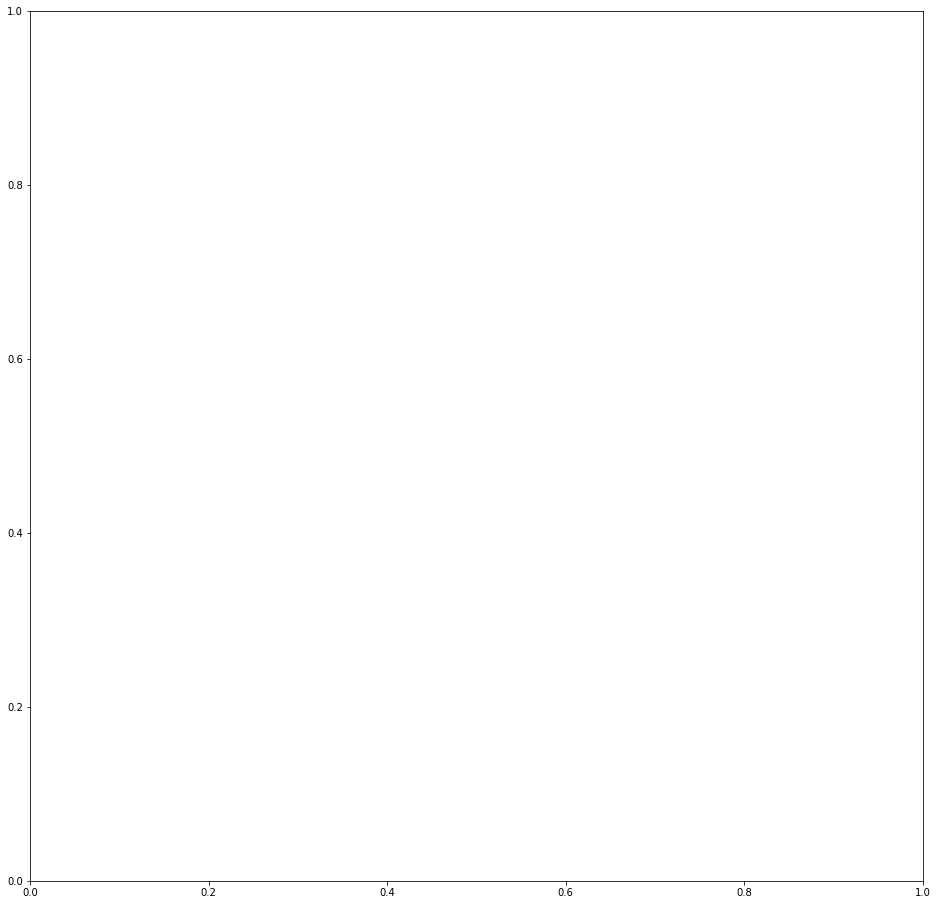

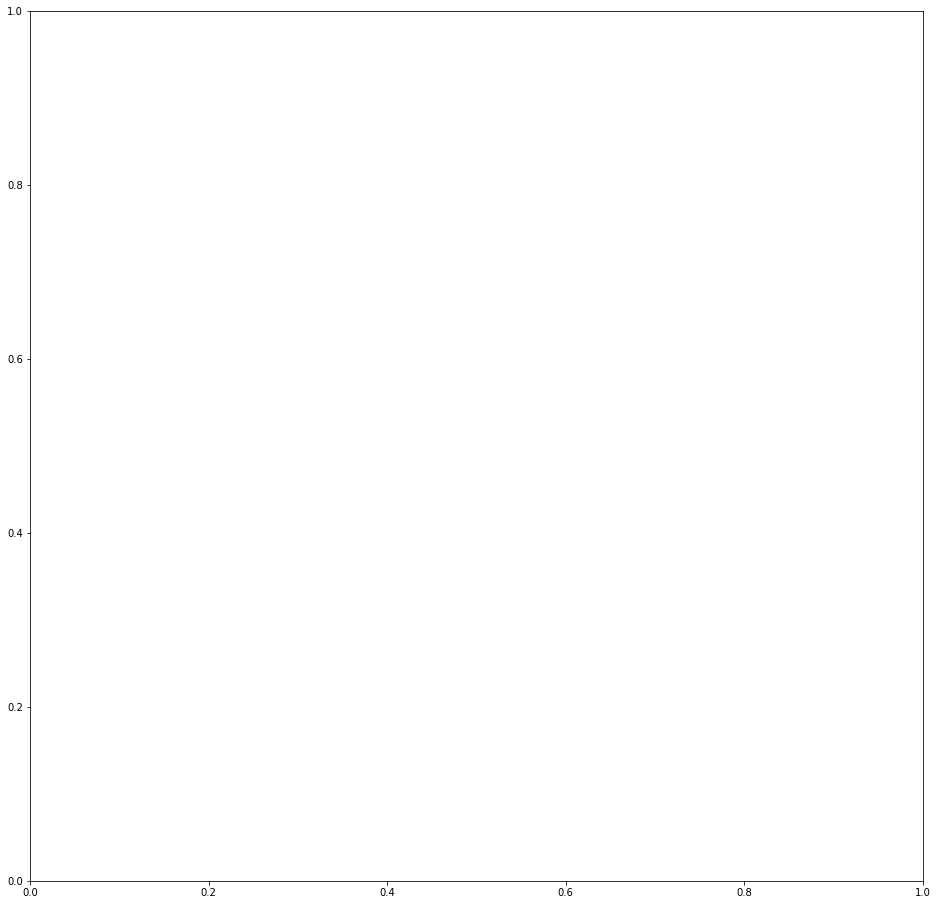

In [115]:
import mrcnn.utils
import pandas as pd
APs = []
ground_truth, prediction = {'bbox':[], 'class_id':[], 'mask':[]}, {'rois':[], 'class_id':[], 'scores':[],'mask':[]}
#key: class, value: AP
class_score =pd.DataFrame(columns = ['gt', 'gt_id','pred','pred_id','recall'])
mAP = result_view()

In [116]:
print("mAP:", mAP)

mAP: 0.4827586214604049


In [126]:
class_score = pd.concat([class_score, pd.DataFrame(APs, columns =['AP'])], axis=1)

In [127]:
# class_score.drop(['AP'],axis=1, inplace=True)
class_score

gt gt_id        pred pred_id    recall        AP
0   Bitter rot     1   White rot       4  0.333333  0.000000
1   Bitter rot     1  Bitter rot       1  0.388889  0.166667
2   Bitter rot     1   White rot       4  0.200000  0.000000
3   Bitter rot     1   White rot       4  0.166667  0.000000
4   Bitter rot     1          BG       0  0.500000  0.000000
5   Bitter rot     1   Sooty/Fly       6  0.333333  0.000000
6   Bitter rot     1          BG       0  0.500000  0.000000
7   Bitter rot     1   Sooty/Fly       6  0.333333  0.000000
8   Bitter rot     1          BG       0  0.500000  0.000000
9   Bitter rot     1  Bitter rot       1  0.333333  0.166667
10  Mar blotch     3          BG       0  0.500000  0.000000
11  Mar blotch     3   White rot       4  0.333333  0.000000
12  Mar blotch     3          BG       0  0.500000  0.000000
13  Mar blotch     3   White rot       4  0.333333  0.000000
14  Mar blotch     3  Mar blotch       3  0.416667  0.333333
15  Mar blotch     3   Sooty/Fly       6  0.250000  0.000000
16  Mar blotch     3  Mar blotch       3  0.333333  0.166667
17  Mar blotch     3          BG       0  0.500000  0.000000
18  Mar blotch     3   Sooty/Fly       6  0.250000  0.000000
19  Mar blotch     3          BG       0  0.500000  0.000000
20   White rot     4   White rot       4  0.416667  0.333333
21   White rot     4   White rot       4  0.666667  1.000000
22   White rot     4   Sooty/Fly       6  0.333333  0.000000
23   White rot     4   White rot       4  0.666667  1.000000
24   White rot     4   White rot       4  0.666667  1.000000
25   White rot     4   White rot       4  0.750000  1.000000
26   White rot     4   White rot       4  0.500000  0.500000
27   White rot     4   White rot       4  0.666667  1.000000
28   White rot     4   White rot       4  0.666667  1.000000
29   White rot     4   White rot       4  0.500000  0.500000
30   Sooty/Fly     6          BG       0  0.500000  0.000000
31   Sooty/Fly     6   Sooty/Fly       6  0.666667  1.000000
32   Sooty/Fly     6   Sooty/Fly       6  0.666667  1.000000
33   Sooty/Fly     6          BG       0  0.500000  0.000000
34   Sooty/Fly     6   Sooty/Fly       6  0.666667  1.000000
35   Sooty/Fly     6          BG       0  0.500000  0.000000
36   Sooty/Fly     6   Sooty/Fly       6  0.666667  1.000000
37   Sooty/Fly     6   Sooty/Fly       6  0.666667  1.000000
38   brown rot     2   brown rot       2  0.666667  1.000000
39   brown rot     2   brown rot       2  0.500000  0.500000
40   brown rot     2   brown rot       2  0.666667  1.000000
41   brown rot     2          BG       0  0.500000  0.000000
42   brown rot     2   brown rot       2  0.666667  1.000000
43   brown rot     2   brown rot       2  0.666667  1.000000
44   brown rot     2   brown rot       2  0.500000  0.500000
45   brown rot     2   brown rot       2  0.666667  1.000000
46   brown rot     2          BG       0  0.500000  0.000000
47   brown rot     2   brown rot       2  0.666667  1.000000
48      Normal     5      Normal       5  0.416667  0.333333
49      Normal     5      Normal       5  0.375000  0.250000
50      Normal     5      Normal       5  0.666667  1.000000
51      Normal     5      Normal       5  0.666667  1.000000
52      Normal     5      Normal       5  0.350000  0.250000
53      Normal     5      Normal       5  0.666667  1.000000
54      Normal     5      Normal       5  0.800000  1.000000
55      Normal     5      Normal       5  0.750000  1.000000
56      Normal     5      Normal       5  0.666667  1.000000
57      Normal     5      Normal       5  0.666667  1.000000

In [16]:
# class_score = class_score.drop('AP', axis=1)
# class_score = pd.concat([class_score, pd.DataFrame(APs, columns =['AP'])], axis=1)
# class_score

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


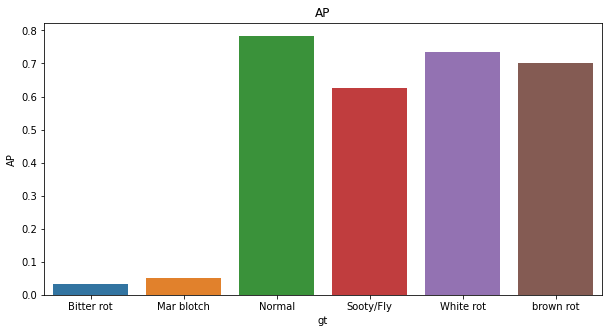

In [128]:
import seaborn as sns
group = class_score.groupby('gt').mean()
plt.figure(figsize=(10,5))
plt.title("AP")
sns.barplot(group.index, group['AP'])
plt.show()

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


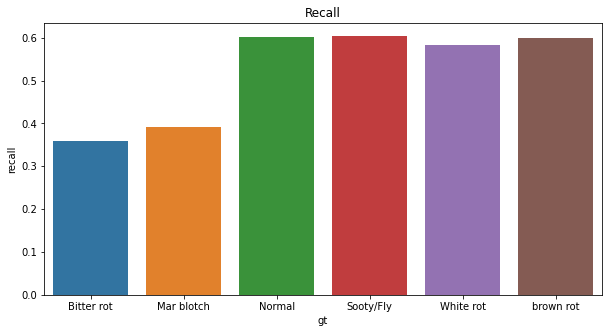

In [130]:
import seaborn as sns
group = class_score.groupby('gt').mean()
plt.figure(figsize=(10,5))
plt.title("Recall")
sns.barplot(group.index, group['recall'])
plt.show()

In [129]:
group

recall        AP
gt                            
Bitter rot  0.358889  0.033333
Mar blotch  0.391667  0.050000
Normal      0.602500  0.783333
Sooty/Fly   0.604167  0.625000
White rot   0.583333  0.733333
brown rot   0.600000  0.700000

In [19]:
group['']

gt
Bitter rot    0.033333
Mar blotch    0.050000
Normal        0.783333
Sooty/Fly     0.625000
White rot     0.733333
brown rot     0.700000
Name: AP, dtype: float64

In [20]:
from collections import defaultdict
def get_recall():
    count_grp = class_score.groupby('gt',as_index=False).count()
    recalls = defaultdict(float)
#     print(count_grp)
    for target in count_grp['gt']:
        tr_cnt = class_score.loc[class_score['gt'] == target].loc[class_score['gt_id'] == class_score['pred_id']].count()[0]
        recalls[target] = tr_cnt/(count_grp.loc[count_grp['gt'] == target]['gt_id'].values[0])
    return recalls

In [21]:
recall_df = pd.DataFrame.from_dict(get_recall(),orient='index',columns=['recall'])

In [22]:
recall_df.reset_index(inplace=True)

In [23]:
recall_df

index  recall
0  Bitter rot   0.200
1  Mar blotch   0.200
2      Normal   1.000
3   Sooty/Fly   0.625
4   White rot   0.900
5   brown rot   0.800

In [24]:
recall_df.set_index('index', inplace=True)

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


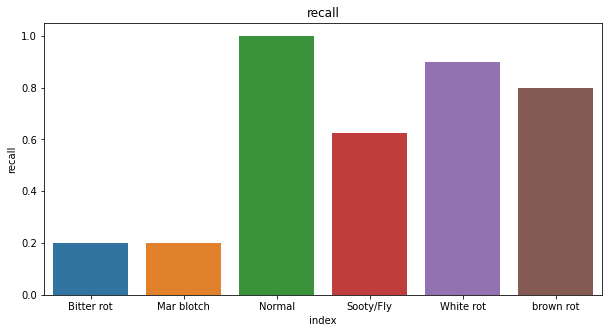

In [25]:
plt.figure(figsize=(10,5))
plt.title('recall')
sns.barplot(recall_df.index, recall_df['recall'])
plt.show()

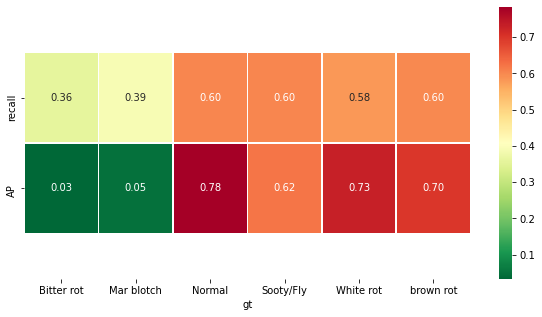

In [131]:
fig = plt.figure(figsize=(10,5))
ax = fig.gca()
ax.cla()
ax = sns.heatmap(group.transpose(), annot= True, cmap='RdYlGn_r', fmt='.2f', linewidths=0.5)
bot,top = ax.get_ylim()
ax.set_ylim(bot+0.5, top-0.5)
plt.show()

# Detail info

In [27]:
image_id =3

image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                           dataset.image_reference(image_id)))
    
# Run object detection
results = model.detect([image], verbose=1)


image ID: apple.Bitter_rot (9).jpg (3) /tf/Mask_RCNN/samples/apple/dataset_3cls/val/Bitter_rot (9).jpg
Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  149.10000  float64
image_metas              shape: (1, 19)               min:    0.00000  max: 1024.00000  int64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


## Color Splash

This is for illustration. You can call `balloon.py` with the `splash` option to get better images without the black padding.

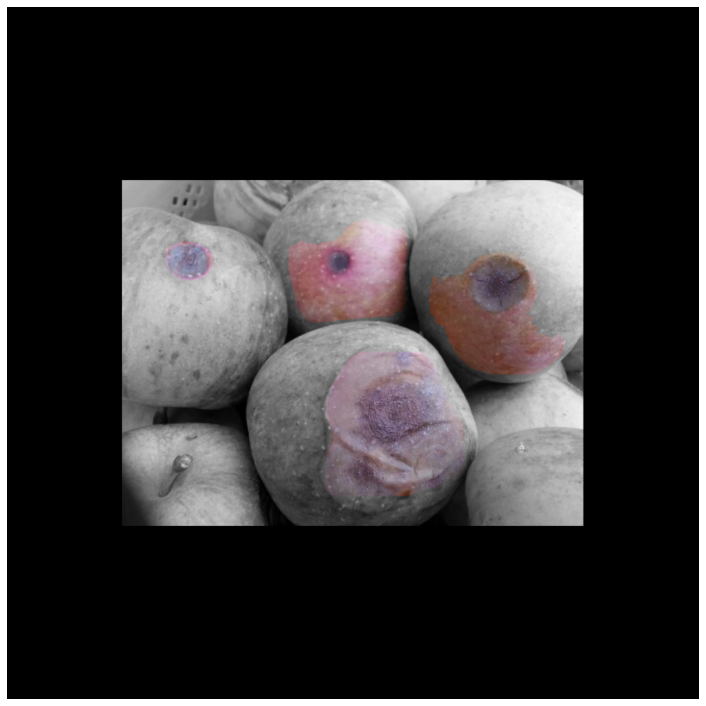

In [28]:
splash = apple.color_splash(image, results[0]['masks'])
display_images([splash], cols=1)

## Step by Step Prediction

## Stage 1: Region Proposal Network

The Region Proposal Network (RPN) runs a lightweight binary classifier on a lot of boxes (anchors) over the image and returns object/no-object scores. Anchors with high *objectness* score (positive anchors) are passed to the stage two to be classified.

Often, even positive anchors don't cover objects fully. So the RPN also regresses a refinement (a delta in location and size) to be applied to the anchors to shift it and resize it a bit to the correct boundaries of the object.

### 1.a RPN Targets

The RPN targets are the training values for the RPN. To generate the targets, we start with a grid of anchors that cover the full image at different scales, and then we compute the IoU of the anchors with ground truth object. Positive anchors are those that have an IoU >= 0.7 with any ground truth object, and negative anchors are those that don't cover any object by more than 0.3 IoU. Anchors in between (i.e. cover an object by IoU >= 0.3 but < 0.7) are considered neutral and excluded from training.

To train the RPN regressor, we also compute the shift and resizing needed to make the anchor cover the ground truth object completely.

In [29]:
# Generate RPN trainig targets
# target_rpn_match is 1 for positive anchors, -1 for negative anchors
# and 0 for neutral anchors.
target_rpn_match, target_rpn_bbox = modellib.build_rpn_targets(
    image.shape, model.anchors, gt_class_id, gt_bbox, model.config)
log("target_rpn_match", target_rpn_match)
log("target_rpn_bbox", target_rpn_bbox)

positive_anchor_ix = np.where(target_rpn_match[:] == 1)[0]
negative_anchor_ix = np.where(target_rpn_match[:] == -1)[0]
neutral_anchor_ix = np.where(target_rpn_match[:] == 0)[0]
positive_anchors = model.anchors[positive_anchor_ix]
negative_anchors = model.anchors[negative_anchor_ix]
neutral_anchors = model.anchors[neutral_anchor_ix]
log("positive_anchors", positive_anchors)
log("negative_anchors", negative_anchors)
log("neutral anchors", neutral_anchors)

# Apply refinement deltas to positive anchors
refined_anchors = utils.apply_box_deltas(
    positive_anchors,
    target_rpn_bbox[:positive_anchors.shape[0]] * model.config.RPN_BBOX_STD_DEV)
log("refined_anchors", refined_anchors, )


target_rpn_match         shape: (261888,)             min:   -1.00000  max:    1.00000  int32
target_rpn_bbox          shape: (256, 4)              min:   -1.76110  max:    1.23918  float64
positive_anchors         shape: (10, 4)               min:  232.00000  max:  800.00000  float64
negative_anchors         shape: (246, 4)              min: -117.01934  max: 1061.25483  float64
neutral anchors          shape: (261632, 4)           min: -362.03867  max: 1322.03867  float64
refined_anchors          shape: (10, 4)               min:  228.00000  max:  781.00000  float32


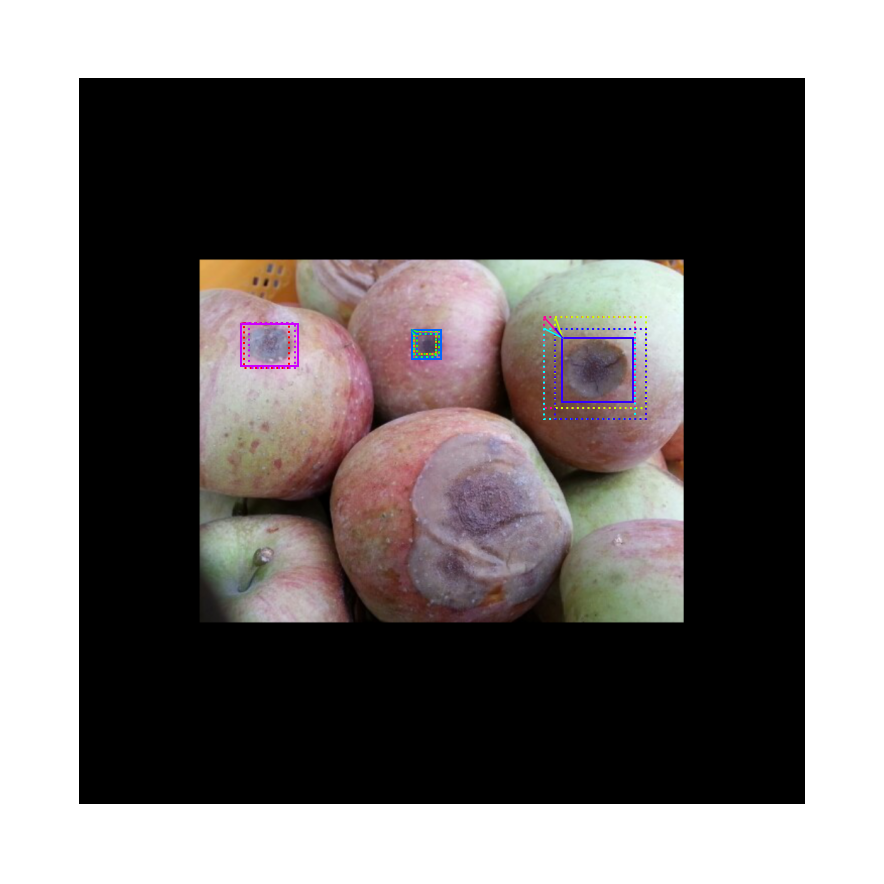

In [30]:
# Display positive anchors before refinement (dotted) and
# after refinement (solid).
visualize.draw_boxes(image, boxes=positive_anchors, refined_boxes=refined_anchors, ax=get_ax())

### 1.b RPN Predictions

Here we run the RPN graph and display its predictions.

In [31]:
# Run RPN sub-graph
pillar = model.keras_model.get_layer("ROI").output  # node to start searching from

# TF 1.4 and 1.9 introduce new versions of NMS. Search for all names to support TF 1.3~1.10
nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression:0")
if nms_node is None:
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV2:0")
if nms_node is None: #TF 1.9-1.10
    nms_node = model.ancestor(pillar, "ROI/rpn_non_max_suppression/NonMaxSuppressionV3:0")

rpn = model.run_graph([image], [
    ("rpn_class", model.keras_model.get_layer("rpn_class").output),
    ("pre_nms_anchors", model.ancestor(pillar, "ROI/pre_nms_anchors:0")),
    ("refined_anchors", model.ancestor(pillar, "ROI/refined_anchors:0")),
    ("refined_anchors_clipped", model.ancestor(pillar, "ROI/refined_anchors_clipped:0")),
    ("post_nms_anchor_ix", nms_node),
    ("proposals", model.keras_model.get_layer("ROI").output),
])

rpn_class                shape: (1, 261888, 2)        min:    0.00000  max:    1.00000  float32
pre_nms_anchors          shape: (1, 6000, 4)          min:   -0.35390  max:    1.29134  float32
refined_anchors          shape: (1, 6000, 4)          min:   -3.49338  max:    4.52558  float32
refined_anchors_clipped  shape: (1, 6000, 4)          min:    0.00000  max:    1.00000  float32
post_nms_anchor_ix       shape: (760,)                min:    0.00000  max: 5997.00000  int32
proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32


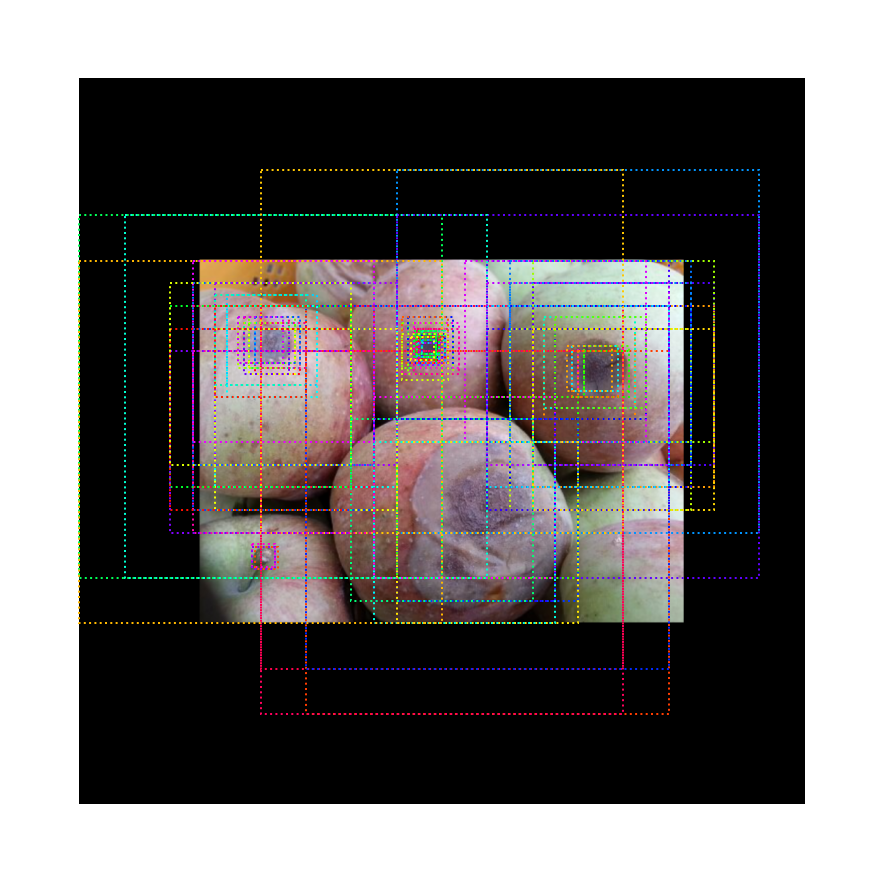

In [32]:
# Show top anchors by score (before refinement)
limit = 100
sorted_anchor_ids = np.argsort(rpn['rpn_class'][:,:,1].flatten())[::-1]
visualize.draw_boxes(image, boxes=model.anchors[sorted_anchor_ids[:limit]], ax=get_ax())

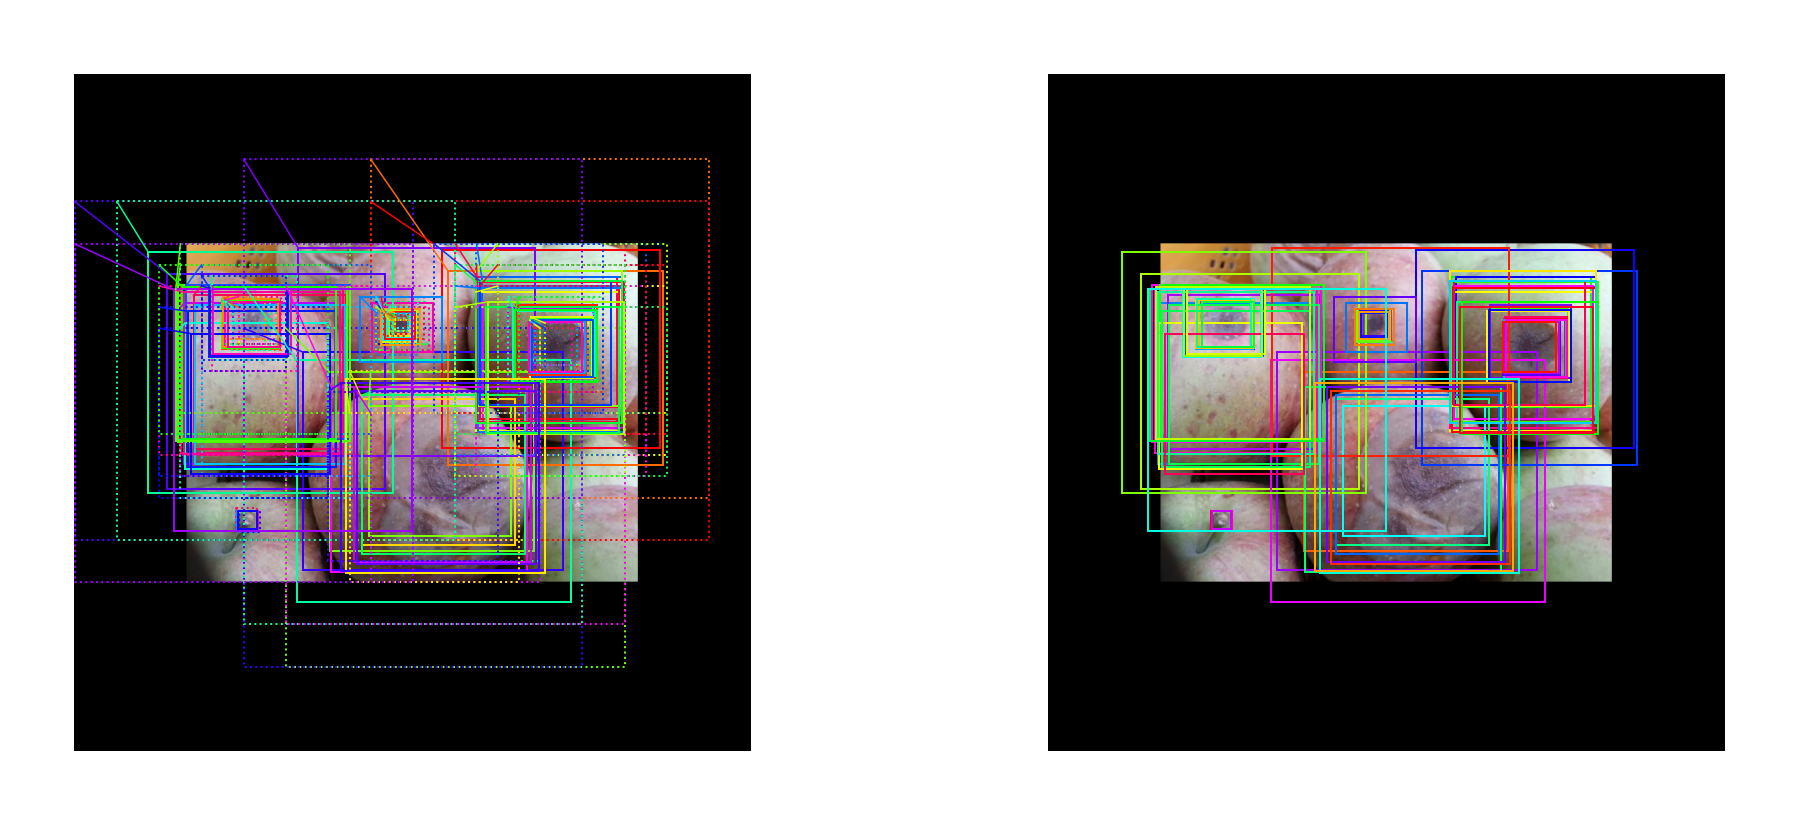

In [33]:
# Show top anchors with refinement. Then with clipping to image boundaries
limit = 100
ax = get_ax(1, 2)
pre_nms_anchors = utils.denorm_boxes(rpn["pre_nms_anchors"][0], image.shape[:2])
refined_anchors = utils.denorm_boxes(rpn["refined_anchors"][0], image.shape[:2])
refined_anchors_clipped = utils.denorm_boxes(rpn["refined_anchors_clipped"][0], image.shape[:2])
visualize.draw_boxes(image, boxes=pre_nms_anchors[:limit],
                     refined_boxes=refined_anchors[:limit], ax=ax[0])
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[:limit], ax=ax[1])

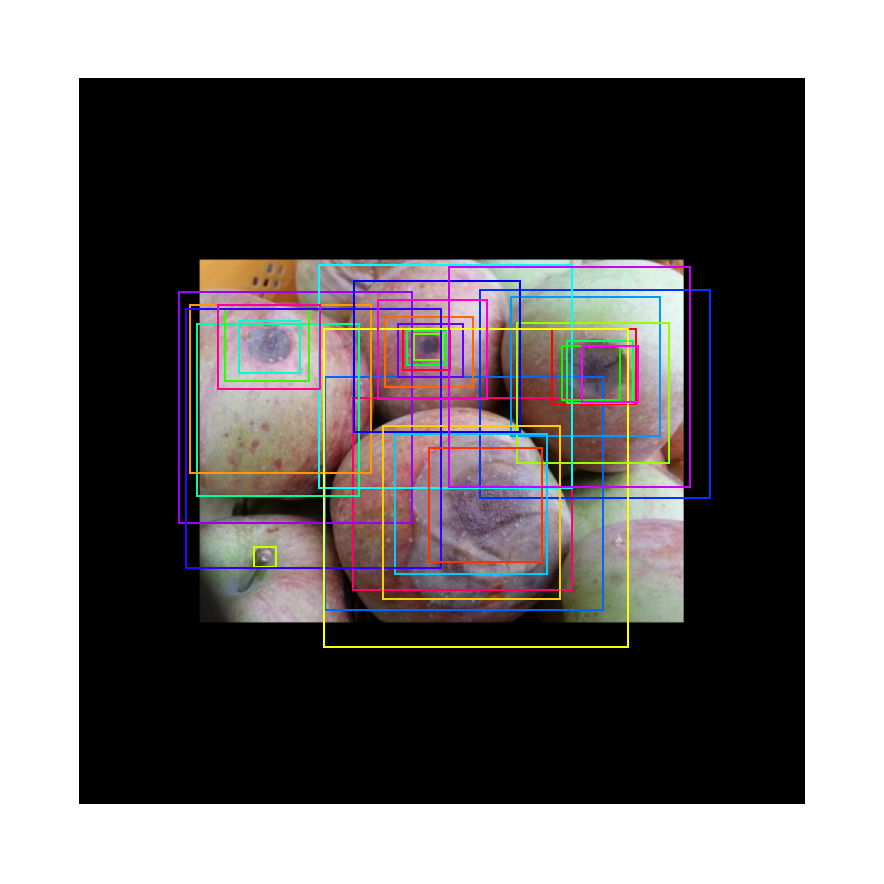

In [34]:
# Show refined anchors after non-max suppression
limit = 30
ixs = rpn["post_nms_anchor_ix"][:limit]
visualize.draw_boxes(image, refined_boxes=refined_anchors_clipped[ixs], ax=get_ax())

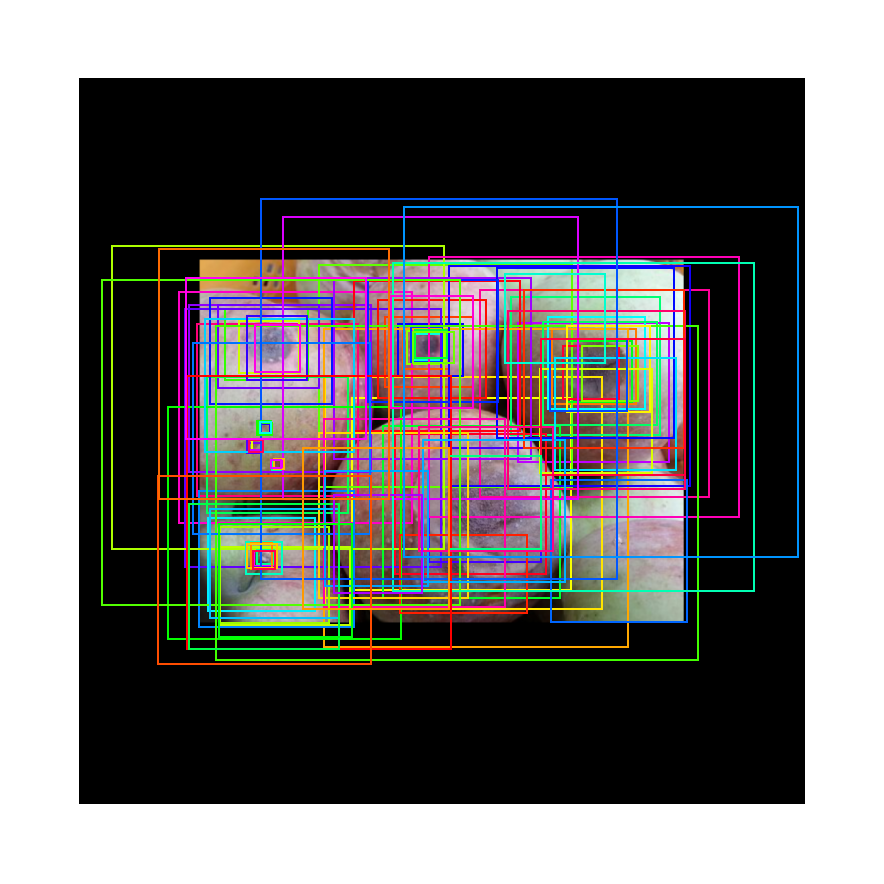

In [35]:
# Show final proposals
# These are the same as the previous step (refined anchors 
# after NMS) but with coordinates normalized to [0, 1] range.
limit = 100
# Convert back to image coordinates for display
h, w = config.IMAGE_SHAPE[:2]
proposals = rpn['proposals'][0, :limit] * np.array([h, w, h, w])
visualize.draw_boxes(image, refined_boxes=proposals, ax=get_ax())

## Stage 2: Proposal Classification

This stage takes the region proposals from the RPN and classifies them.

### 2.a Proposal Classification

Run the classifier heads on proposals to generate class propbabilities and bounding box regressions.

In [36]:
# Get input and output to classifier and mask heads.
mrcnn = model.run_graph([image], [
    ("proposals", model.keras_model.get_layer("ROI").output),
    ("probs", model.keras_model.get_layer("mrcnn_class").output),
    ("deltas", model.keras_model.get_layer("mrcnn_bbox").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
])

proposals                shape: (1, 1000, 4)          min:    0.00000  max:    1.00000  float32
probs                    shape: (1, 1000, 7)          min:    0.00000  max:    1.00000  float32
deltas                   shape: (1, 1000, 7, 4)       min:   -3.73099  max:    4.11973  float32
masks                    shape: (1, 100, 28, 28, 7)   min:    0.00002  max:    1.00000  float32
detections               shape: (1, 100, 6)           min:    0.00000  max:    4.00000  float32


4it [00:00, 25458.60it/s]

4 detections: ['White rot' 'White rot' 'White rot' 'White rot']


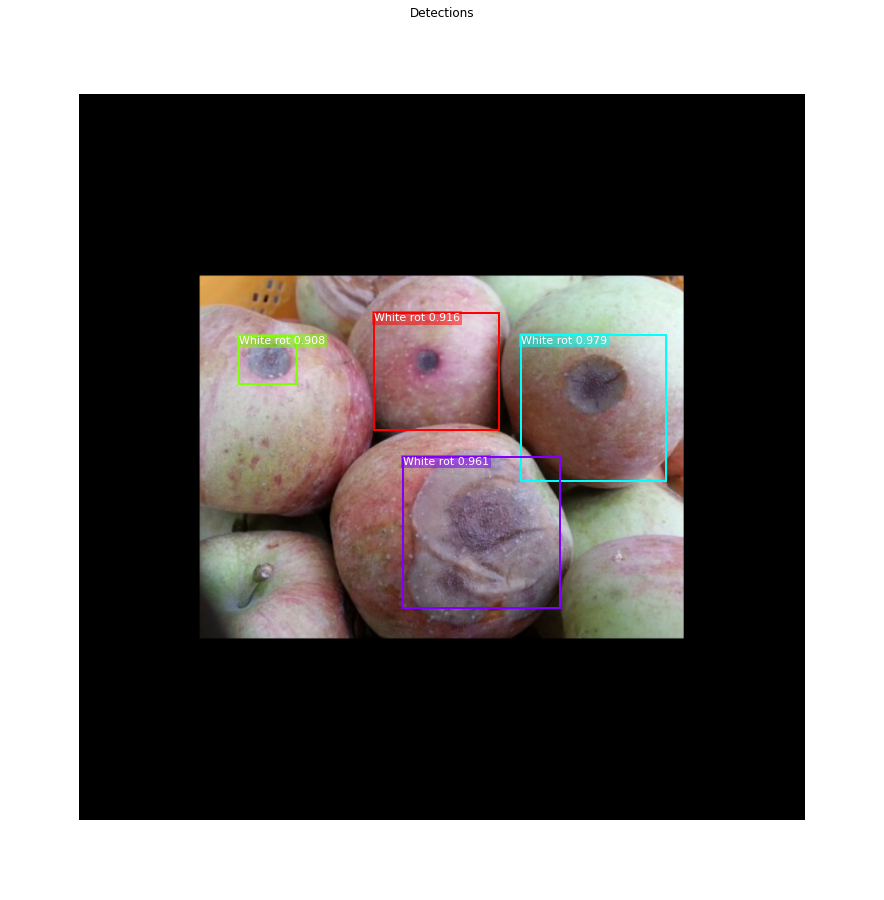

In [37]:
# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]
detections = mrcnn['detections'][0, :det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

captions = ["{} {:.3f}".format(dataset.class_names[int(c)], s) if c > 0 else ""
            for c, s in tqdm(zip(detections[:, 4], detections[:, 5]))]
visualize.draw_boxes(
    image, 
    refined_boxes=utils.denorm_boxes(detections[:, :4], image.shape[:2]),
    visibilities=[2] * len(detections),
    captions=captions, title="Detections",
    ax=get_ax())

### 2.c Step by Step Detection

Here we dive deeper into the process of processing the detections.

In [38]:
# Proposals are in normalized coordinates. Scale them
# to image coordinates.
h, w = config.IMAGE_SHAPE[:2]
proposals = np.around(mrcnn["proposals"][0] * np.array([h, w, h, w])).astype(np.int32)

# Class ID, score, and mask per proposal
roi_class_ids = np.argmax(mrcnn["probs"][0], axis=1)
roi_scores = mrcnn["probs"][0, np.arange(roi_class_ids.shape[0]), roi_class_ids]
roi_class_names = np.array(dataset.class_names)[roi_class_ids]
roi_positive_ixs = np.where(roi_class_ids > 0)[0]

# How many ROIs vs empty rows?
print("{} Valid proposals out of {}".format(np.sum(np.any(proposals, axis=1)), proposals.shape[0]))
print("{} Positive ROIs".format(len(roi_positive_ixs)))

# Class counts
print(list(zip(*np.unique(roi_class_names, return_counts=True))))

760 Valid proposals out of 1000
85 Positive ROIs
[('BG', 915), ('Bitter rot', 8), ('Sooty/Fly', 9), ('White rot', 68)]


5it [00:00, 41527.76it/s]


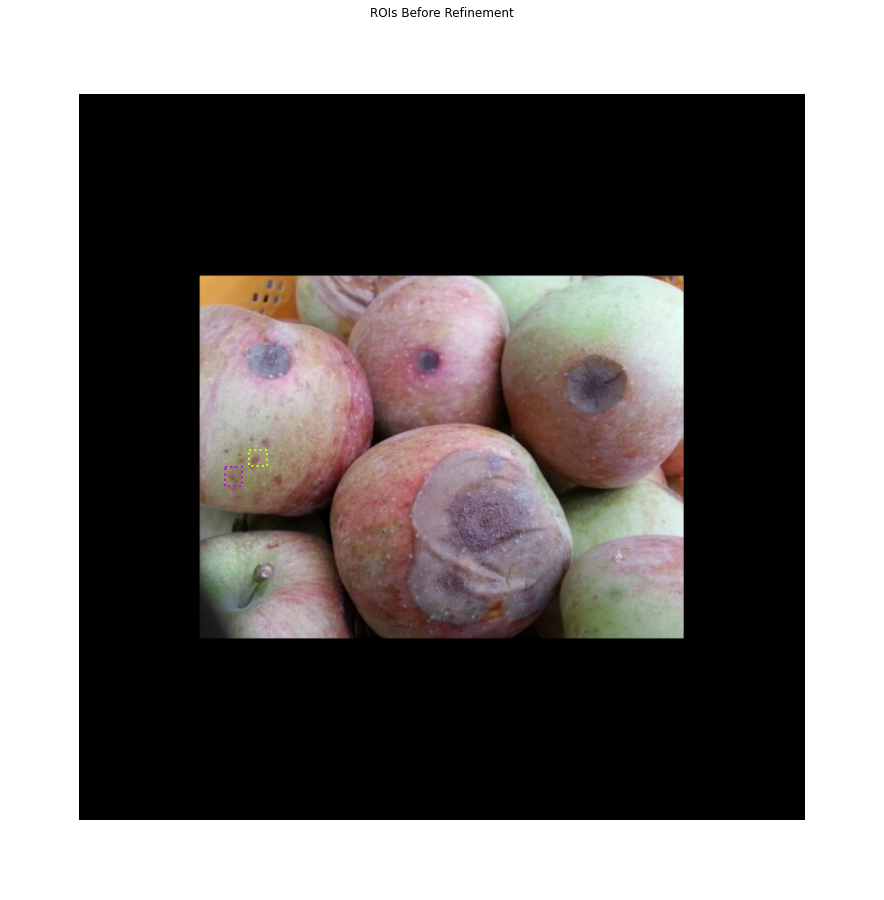

In [39]:
# Display a random sample of proposals.
# Proposals classified as background are dotted, and
# the rest show their class and confidence score.
limit = 5
ixs = np.random.randint(0, proposals.shape[0], limit)
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in tqdm(zip(roi_class_ids[ixs], roi_scores[ixs]))]
visualize.draw_boxes(image, boxes=proposals[ixs],
                     visibilities=np.where(roi_class_ids[ixs] > 0, 2, 1),
                     captions=captions, title="ROIs Before Refinement",
                     ax=get_ax())

#### Apply Bounding Box Refinement

5it [00:00, 16967.25it/s]

roi_bbox_specific        shape: (1000, 4)             min:   -2.92358  max:    2.79352  float32
refined_proposals        shape: (1000, 4)             min: -104.00000  max: 1163.00000  int32


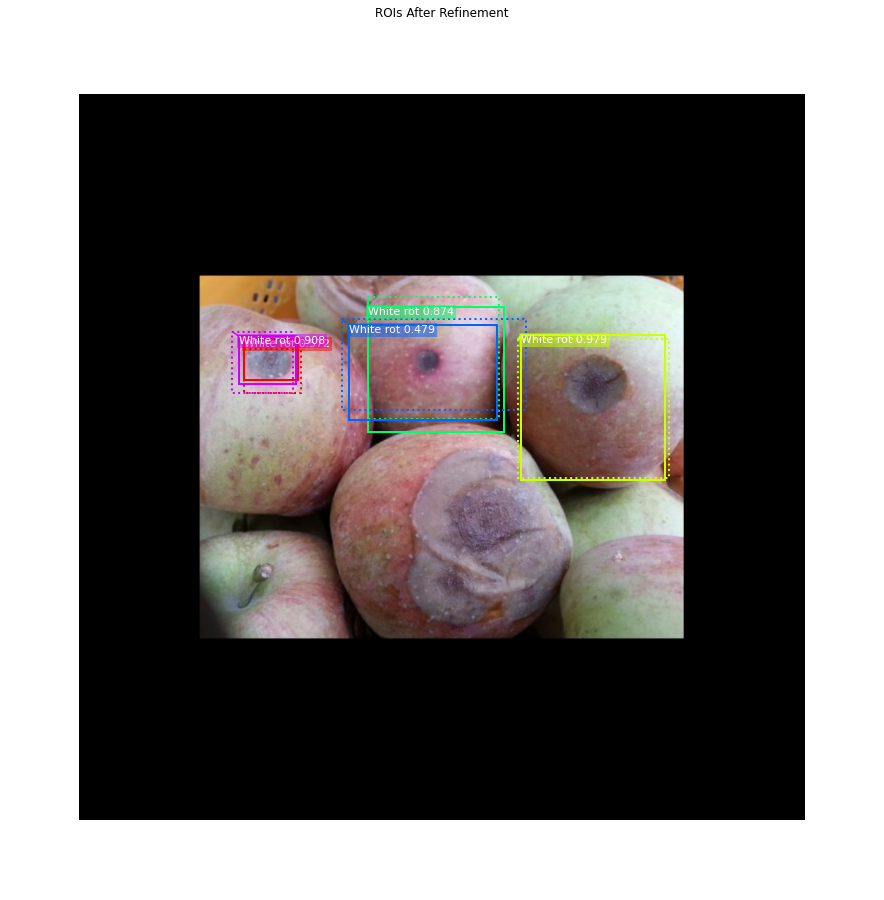

In [40]:
# Class-specific bounding box shifts.
roi_bbox_specific = mrcnn["deltas"][0, np.arange(proposals.shape[0]), roi_class_ids]
log("roi_bbox_specific", roi_bbox_specific)

# Apply bounding box transformations
# Shape: [N, (y1, x1, y2, x2)]
refined_proposals = utils.apply_box_deltas(
    proposals, roi_bbox_specific * config.BBOX_STD_DEV).astype(np.int32)
log("refined_proposals", refined_proposals)

# Show positive proposals
# ids = np.arange(roi_boxes.shape[0])  # Display all
limit = 5
ids = np.random.randint(0, len(roi_positive_ixs), limit)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in tqdm(zip(roi_class_ids[roi_positive_ixs][ids], roi_scores[roi_positive_ixs][ids]))]
visualize.draw_boxes(image, boxes=proposals[roi_positive_ixs][ids],
                     refined_boxes=refined_proposals[roi_positive_ixs][ids],
                     visibilities=np.where(roi_class_ids[roi_positive_ixs][ids] > 0, 1, 0),
                     captions=captions, title="ROIs After Refinement",
                     ax=get_ax())

#### Filter Low Confidence Detections

In [41]:
# Remove boxes classified as background
keep = np.where(roi_class_ids > 0)[0]
print("Keep {} detections:\n{}".format(keep.shape[0], keep))

Keep 85 detections:
[  0   1   2   3   4   6   7   8   9  10  11  13  14  16  20  21  22  23
  25  29  32  33  41  42  45  47  52  55  56  57  58  59  60  62  67  68
  72  74  78  84  85  86 103 110 119 120 122 125 129 138 140 141 150 156
 161 164 176 179 185 188 193 199 208 221 223 224 248 257 267 316 328 330
 333 354 387 392 396 449 472 489 605 681 693 709 741]


In [42]:
# Remove low confidence detections
keep = np.intersect1d(keep, np.where(roi_scores >= config.DETECTION_MIN_CONFIDENCE)[0])
print("Remove boxes below {} confidence. Keep {}:\n{}".format(
    config.DETECTION_MIN_CONFIDENCE, keep.shape[0], keep))

Remove boxes below 0.9 confidence. Keep 12:
[  6  10  11  20  23  84  85  86 119 156 185 223]


#### Per-Class Non-Max Suppression

In [43]:
# Apply per-class non-max suppression
pre_nms_boxes = refined_proposals[keep]
pre_nms_scores = roi_scores[keep]
pre_nms_class_ids = roi_class_ids[keep]

nms_keep = []
for class_id in tqdm(np.unique(pre_nms_class_ids)):
    # Pick detections of this class
    ixs = np.where(pre_nms_class_ids == class_id)[0]
    # Apply NMS
    class_keep = utils.non_max_suppression(pre_nms_boxes[ixs], 
                                            pre_nms_scores[ixs],
                                            config.DETECTION_NMS_THRESHOLD)
    # Map indicies
    class_keep = keep[ixs[class_keep]]
    nms_keep = np.union1d(nms_keep, class_keep)
    print("{:22}: {} -> {}".format(dataset.class_names[class_id][:20], 
                                   keep[ixs], class_keep))

keep = np.intersect1d(keep, nms_keep).astype(np.int32)
print("\nKept after per-class NMS: {}\n{}".format(keep.shape[0], keep))

100%|██████████| 1/1 [00:00<00:00, 774.14it/s]

White rot             : [  6  10  11  20  23  84  85  86 119 156 185 223] -> [ 10  84 119 156]

Kept after per-class NMS: 4
[ 10  84 119 156]


4it [00:00, 19878.22it/s]


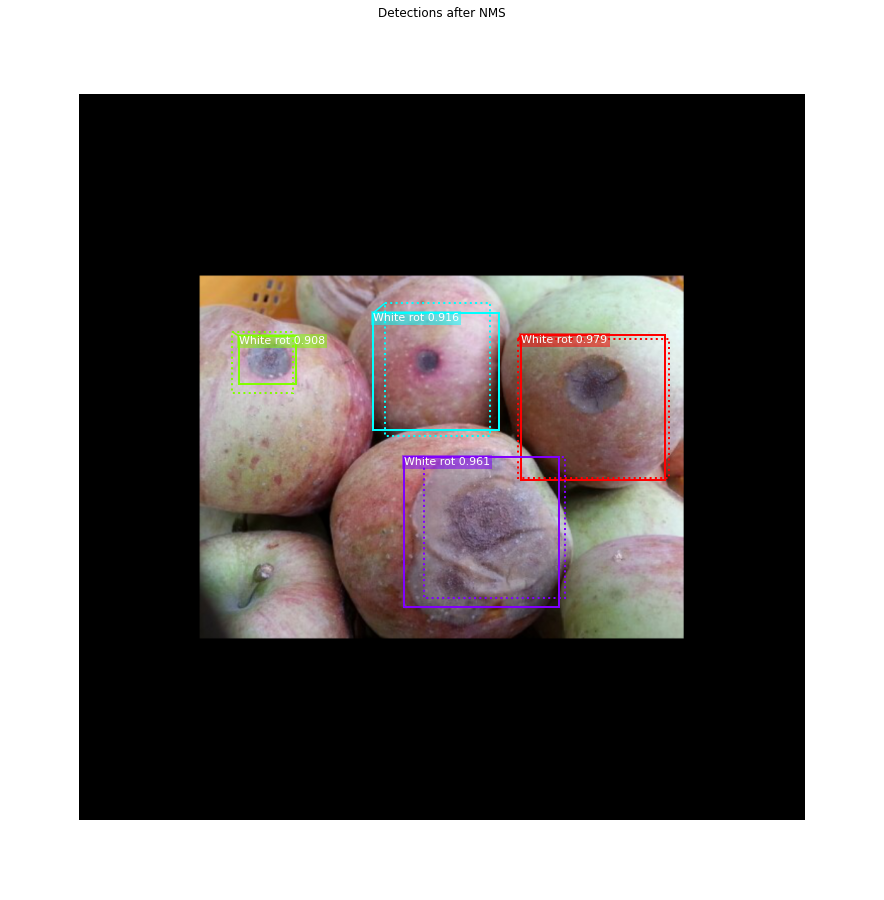

In [44]:
# Show final detections
ixs = np.arange(len(keep))  # Display all
# ixs = np.random.randint(0, len(keep), 10)  # Display random sample
captions = ["{} {:.3f}".format(dataset.class_names[c], s) if c > 0 else ""
            for c, s in tqdm(zip(roi_class_ids[keep][ixs], roi_scores[keep][ixs]))]
visualize.draw_boxes(
    image, boxes=proposals[keep][ixs],
    refined_boxes=refined_proposals[keep][ixs],
    visibilities=np.where(roi_class_ids[keep][ixs] > 0, 1, 0),
    captions=captions, title="Detections after NMS",
    ax=get_ax())

## Stage 3: Generating Masks

This stage takes the detections (refined bounding boxes and class IDs) from the previous layer and runs the mask head to generate segmentation masks for every instance.

### 3.a Mask Targets

These are the training targets for the mask branch

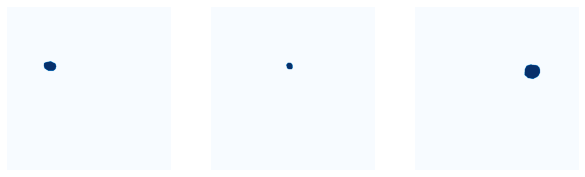

In [45]:
display_images(np.transpose(gt_mask, [2, 0, 1]), cmap="Blues")

### 3.b Predicted Masks

In [46]:
# Get predictions of mask head
mrcnn = model.run_graph([image], [
    ("detections", model.keras_model.get_layer("mrcnn_detection").output),
    ("masks", model.keras_model.get_layer("mrcnn_mask").output),
])

# Get detection class IDs. Trim zero padding.
det_class_ids = mrcnn['detections'][0, :, 4].astype(np.int32)
det_count = np.where(det_class_ids == 0)[0][0]
det_class_ids = det_class_ids[:det_count]

print("{} detections: {}".format(
    det_count, np.array(dataset.class_names)[det_class_ids]))

detections               shape: (1, 100, 6)           min:    0.00000  max:    4.00000  float32
masks                    shape: (1, 100, 28, 28, 7)   min:    0.00002  max:    1.00000  float32
4 detections: ['White rot' 'White rot' 'White rot' 'White rot']


In [47]:
# Masks
det_boxes = utils.denorm_boxes(mrcnn["detections"][0, :, :4], image.shape[:2])
det_mask_specific = np.array([mrcnn["masks"][0, i, :, :, c] 
                              for i, c in tqdm(enumerate(det_class_ids))])
det_masks = np.array([utils.unmold_mask(m, det_boxes[i], image.shape)
                      for i, m in tqdm(enumerate(det_mask_specific))])
log("det_mask_specific", det_mask_specific)
log("det_masks", det_masks)

4it [00:00, 31536.12it/s]
4it [00:00, 497.47it/s]

det_mask_specific        shape: (4, 28, 28)           min:    0.00002  max:    1.00000  float32
det_masks                shape: (4, 1024, 1024)       min:    0.00000  max:    1.00000  bool


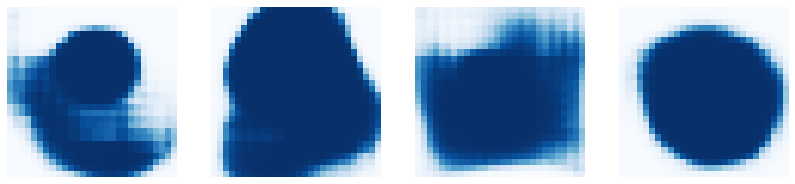

In [48]:
display_images(det_mask_specific[:4] * 255, cmap="Blues", interpolation="none")

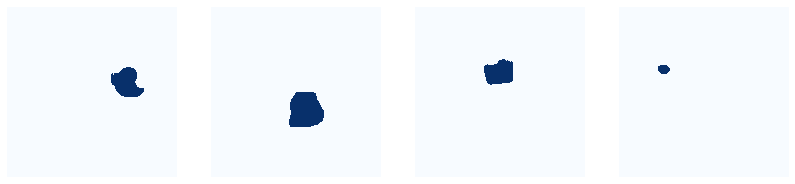

In [49]:
display_images(det_masks[:4] * 255, cmap="Blues", interpolation="none")

## Visualize Activations

In some cases it helps to look at the output from different layers and visualize them to catch issues and odd patterns.

In [50]:
# # Get activations of a few sample layers
# activations = model.run_graph([image], [
#     ("input_image",        tf.identity(model.keras_model.get_layer("input_image").output)),
#     ("res2c_out",          model.keras_model.get_layer("res2c_out").output),
#     ("res3c_out",          model.keras_model.get_layer("res3c_out").output),
#     ("res4w_out",          model.keras_model.get_layer("res4w_out").output),  # for resnet100
#     ("rpn_bbox",           model.keras_model.get_layer("rpn_bbox").output),
#     ("roi",                model.keras_model.get_layer("ROI").output),
# ])

In [51]:
# # Input image (normalized)
# _ = plt.imshow(modellib.unmold_image(activations["input_image"][0],config))

In [52]:
# # Backbone feature map
# display_images(np.transpose(activations["res2c_out"][0,:,:,:4], [2, 0, 1]), cols=4)